In [3]:
from scipy.io import wavfile
import pandas as pd
import numpy as np
import os
import librosa, librosa.display
from tqdm import tqdm
import IPython.display as ipd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'Malgun Gothic' # Windows
matplotlib.rcParams['font.size'] = 15 # 글자 크기
matplotlib.rcParams['axes.unicode_minus'] = False # 한글 폰트 사용시, 마이너스 글자가 깨지는 현상을 해결
import seaborn as sns
import sklearn.preprocessing

import warnings
warnings.filterwarnings(action='ignore')

In [4]:
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') #GPU 할당

# data upload

In [3]:
# train data
folder = './data/train/'
dataset = []
for file in tqdm(os.listdir(folder),colour='green'):
    if 'wav' in file:
        abs_file_path = os.path.join(folder,file)
        data,sr = librosa.load(abs_file_path,sr=16000)
        dataset.append(data)
print('완료')

100%|██████████████████████████████████████████████████████████████████████████████| 3805/3805 [16:03<00:00,  3.95it/s]

완료


In [184]:
# test data
folder = './data/test/'
dataset_test = []
for file in tqdm(os.listdir(folder),colour='green'):
    if 'wav' in file:
        abs_file_path = os.path.join(folder,file)
        data,sr = librosa.load(abs_file_path,sr=16000)
        dataset_test.append(data)
print('완료')

100%|██████████████████████████████████████████████████████████████████████████████| 5732/5732 [25:21<00:00,  3.77it/s]

완료


In [191]:
dataset_test

[array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -1.2836668e-06, -1.8928910e-06,  3.8331424e-07], dtype=float32),
 array([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         1.1625224e-05,  7.5002026e-06, -7.7637842e-06], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -7.7541794e-05, -4.1334726e-05, -1.1255575e-04], dtype=float32),
 array([ 0.        ,  0.        ,  0.        , ...,  0.00041153,
        -0.00288247, -0.00311873], dtype=float32),
 array([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         1.6616816e-05,  6.9859569e-05, -1.3590248e-04], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([ 0.        ,  0.        ,  0.        , ...,  0.01822334,
        -0.01

In [188]:
np.array(dataset_test)

array([array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
       array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
       array([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
              -1.2836668e-06, -1.8928910e-06,  3.8331424e-07], dtype=float32),
       ...,
       array([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
              -2.1713556e-07,  6.5840243e-07, -6.9418820e-06], dtype=float32),
       array([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
               2.8376985e-06,  1.0392500e-05, -5.4606385e-06], dtype=float32),
       array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)], dtype=object)

In [193]:
with open('test.npy', 'wb') as f:
    np.save(f,dataset_test)

In [194]:
with open('test.npy', 'rb') as f:
    dataset_test2 = np.load(f,allow_pickle=True)

In [3]:
dataset_test2

NameError: name 'dataset_test2' is not defined

In [6]:
# id를 제외한 csv파일을 불러옴
data1 = pd.read_csv('./data/train_data.csv')
data1 = data1.drop(columns=['id'])
data1

age  gender  respiratory_condition  fever_or_muscle_pain  covid19
0      24  female                      0                     1        0
1      51    male                      0                     0        0
2      22    male                      0                     0        0
3      29  female                      1                     0        0
4      23    male                      0                     0        0
...   ...     ...                    ...                   ...      ...
3800   53    male                      0                     0        0
3801   25    male                      0                     0        0
3802   26  female                      0                     0        0
3803   27  female                      0                     0        0
3804   49  female                      1                     1        0

[3805 rows x 5 columns]

# EDA 및 데이터 전처리

결측치를 확인합니다.

In [7]:
# 결측치 확인
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3805 entries, 0 to 3804
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   age                    3805 non-null   int64 
 1   gender                 3805 non-null   object
 2   respiratory_condition  3805 non-null   int64 
 3   fever_or_muscle_pain   3805 non-null   int64 
 4   covid19                3805 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 148.8+ KB


3805개의 데이터가 전부 채워져 있으므로 결측치는 없습니다.

데이터 종류 또한 5개 (나이, 성별, 호흡기 증상, 발열 혹은 근육 통증, 코로나 양성 여부)로 되어있는 것을 볼 수 있습니다.

In [8]:
print(len(data1['age'].unique()))
print(len(data1['gender'].unique()))
print(len(data1['respiratory_condition'].unique()))
print(len(data1['fever_or_muscle_pain'].unique()))
print(len(data1['covid19'].unique()))

86
3
2
2
2


- 특성 종류가 각각 86, 3, 2, 2, 2임을 볼 수 있습니다.
- 여기서 중요한 것은 성별입니다.
    - 여성, 남성 뿐만 아니라 other도 있으니 주의해야합니다.

In [9]:
data1['gender'].unique()

array(['female', 'male', 'other'], dtype=object)

- 성별 특성이 3개로 female, male, other로 되어있습니다.

- female, male을 제외한 other 데이터를 확인합니다.

In [10]:
data1[data1['gender']=='other']

age gender  respiratory_condition  fever_or_muscle_pain  covid19
28     39  other                      0                     0        0
41     16  other                      1                     0        0
129     1  other                      1                     0        0
140    21  other                      0                     1        1
401    26  other                      0                     0        1
408     1  other                      1                     1        0
438    23  other                      0                     0        0
520    13  other                      0                     0        0
825    24  other                      0                     0        0
845    17  other                      0                     0        0
1253   27  other                      0                     0        0
1359   23  other                      1                     0        1
1564   42  other                      1                     1        1
1575   18  other                      0                     0        0
1768   40  other                      0                     0        0
1993   13  other                      1                     0        0
2005   16  other                      0                     0        0
2286   14  other                      0                     0        1
2533    2  other                      1                     0        1
2792   25  other                      0                     0        0
3042   30  other                      1                     0        0
3190   15  other                      1                     1        0
3487   17  other                      0                     0        1
3602   16  other                      1                     0        0
3754    1  other                      1                     1        1
3758   13  other                      1                     0        1

In [11]:
# 성별이 other인 데이터의 개수
print(len(data1[data1['gender']=='other']))

26


- 각 특성별 데이터 개수를 확인합니다.

In [12]:
# 나이
print(data1['age'].value_counts().sort_index())

1     9
2     2
3     1
4     4
5     2
     ..
83    5
84    1
86    1
89    1
90    2
Name: age, Length: 86, dtype: int64


In [13]:
# 성별
print(data1['gender'].value_counts().sort_index())

female    1173
male      2606
other       26
Name: gender, dtype: int64


In [14]:
#  호흡기 질환 여부
print(data1['respiratory_condition'].value_counts().sort_index())

0    3254
1     551
Name: respiratory_condition, dtype: int64


In [15]:
# 발열 혹은 근육통 증상 여부
print(data1['fever_or_muscle_pain'].value_counts().sort_index())

0    3483
1     322
Name: fever_or_muscle_pain, dtype: int64


In [16]:
# 코로나19 음성/양성 여부 (음성:0, 양성:1)
print(data1['covid19'].value_counts().sort_index())

0    3499
1     306
Name: covid19, dtype: int64


- 데이터을 describe 함수로 분석합니다.

In [17]:
# gender를 제외한 data 분석
data1.describe()

age  respiratory_condition  fever_or_muscle_pain      covid19
count  3805.000000            3805.000000           3805.000000  3805.000000
mean     36.768463               0.144809              0.084625     0.080420
std      14.708248               0.351955              0.278360     0.271979
min       1.000000               0.000000              0.000000     0.000000
25%      25.000000               0.000000              0.000000     0.000000
50%      35.000000               0.000000              0.000000     0.000000
75%      46.000000               0.000000              0.000000     0.000000
max      90.000000               1.000000              1.000000     1.000000

- 성별은 female, male, other로 문자로 되어있습니다.
- 딥러닝 모델을 만들기 위해서는 문자열을 숫자로 반드시 변경해줘야 합니다.
- 이에 scikit-learn에서 제공하는 preprocessing을 이용하여 변경합니다.

In [18]:
# sklearn에서 제공하는 label encoder로 female은 0, male은 1, other은 2로 변경 
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
data1['gender']=label_encoder.fit_transform(data1['gender'])
data1

age  gender  respiratory_condition  fever_or_muscle_pain  covid19
0      24       0                      0                     1        0
1      51       1                      0                     0        0
2      22       1                      0                     0        0
3      29       0                      1                     0        0
4      23       1                      0                     0        0
...   ...     ...                    ...                   ...      ...
3800   53       1                      0                     0        0
3801   25       1                      0                     0        0
3802   26       0                      0                     0        0
3803   27       0                      0                     0        0
3804   49       0                      1                     1        0

[3805 rows x 5 columns]

In [19]:
# gender를 포함한 data1의 describe
data1.describe()

age       gender  respiratory_condition  fever_or_muscle_pain  \
count  3805.000000  3805.000000            3805.000000           3805.000000   
mean     36.768463     0.698555               0.144809              0.084625   
std      14.708248     0.473605               0.351955              0.278360   
min       1.000000     0.000000               0.000000              0.000000   
25%      25.000000     0.000000               0.000000              0.000000   
50%      35.000000     1.000000               0.000000              0.000000   
75%      46.000000     1.000000               0.000000              0.000000   
max      90.000000     2.000000               1.000000              1.000000   

           covid19  
count  3805.000000  
mean      0.080420  
std       0.271979  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       0.000000  
max       1.000000

- 이에 데이터를 시각화 합니다.

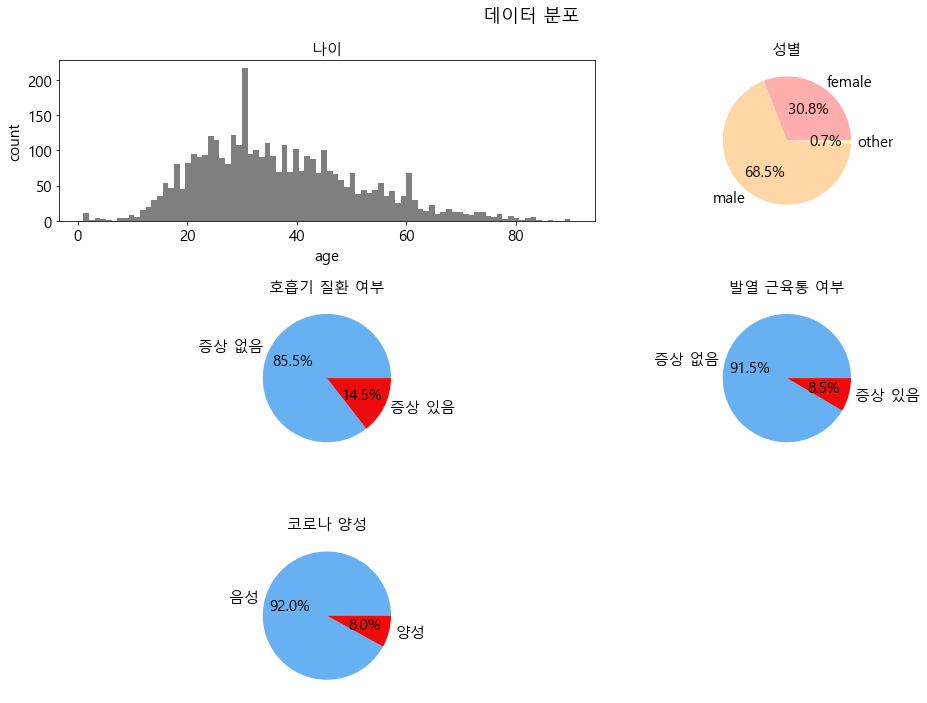

In [20]:
def data_csv_plot():
    # bin 개수를 len를 통하여 정함
    a = len(data1['age'].unique())
    b = len(data1['respiratory_condition'].unique())
    c = len(data1['fever_or_muscle_pain'].unique())
    d = len(data1['covid19'].unique())
    fig, axs = plt.subplots(3,2,figsize=(15,10))
    fig.suptitle('데이터 분포')

    # 나이
    axs[0,0].hist(data1['age'],bins=a,alpha=0.5,color='k') # 데이터 설정 
    axs[0,0].set(xlabel='age', ylabel='count') # x, y 축 label
    axs[0,0].set_title('나이',size=15) # 제목
    
    # 성별
    colors = ['#ffadad', '#ffd6a5', '#fdffb6']
    labels = ['female', 'male', 'other']
    axs[0,1].pie(data1['gender'].value_counts().sort_index(),colors=colors,labels=labels,autopct="%.1f%%")
    axs[0,1].set_title('성별',size=15) # 제목

    # 호흡기 증상 여부
    colors = ['#67B0F1', '#EF0B0B']
    labels = ['증상 없음', '증상 있음']
    axs[1,0].pie(data1['respiratory_condition'].value_counts(),colors=colors,labels=labels,autopct="%.1f%%")
    axs[1,0].set_title('호흡기 질환 여부',size=15) # 제목
    
    # 발열 혹은 근육통 증상 여부
    colors = ['#67B0F1', '#EF0B0B']
    labels = ['증상 없음', '증상 있음']
    axs[1,1].pie(data1['fever_or_muscle_pain'].value_counts(),colors=colors,labels=labels,autopct="%.1f%%")
    axs[1,1].set_title('발열 근육통 여부',size=15) # 제목
    
    # 코로나 양성 여부
    colors = ['#67B0F1', '#EF0B0B']
    labels = ['음성', '양성']
    axs[2,0].pie(data1['covid19'].value_counts(),colors=colors,labels=labels,autopct="%.1f%%")
    axs[2,0].set_title('코로나 양성',size=15) # 제목
    
    fig.delaxes(axs[2][1])
    fig.tight_layout()
    plt.show()
    
data_csv_plot()

- 나이는 30세가 가장 많고 20세 이하, 60세 이상은 거의 없습니다.
- 20 ~ 60세가 가장 많았으며 호흡상태, 열 근육 통증, 코로나는 분포도가 거의 동일하였습니다.

- 이에 코로나가 걸린 사람의 나이와 호흡기 상태, 발열 근육 통증을 분석해보도록 하겠습니다.

In [21]:
covid_data = data1[data1['covid19']==1]
covid_data.reset_index(drop=True,inplace=True)

In [22]:
covid_data

age  gender  respiratory_condition  fever_or_muscle_pain  covid19
0     33       1                      0                     0        1
1     30       1                      0                     0        1
2     24       0                      0                     0        1
3     31       0                      1                     0        1
4     12       0                      0                     1        1
..   ...     ...                    ...                   ...      ...
301   41       1                      0                     0        1
302   13       2                      1                     0        1
303   27       1                      1                     1        1
304   34       1                      0                     0        1
305   17       1                      0                     0        1

[306 rows x 5 columns]

- 코로나 양성인 사람들의 증상을 시각화 하여 분석합니다.

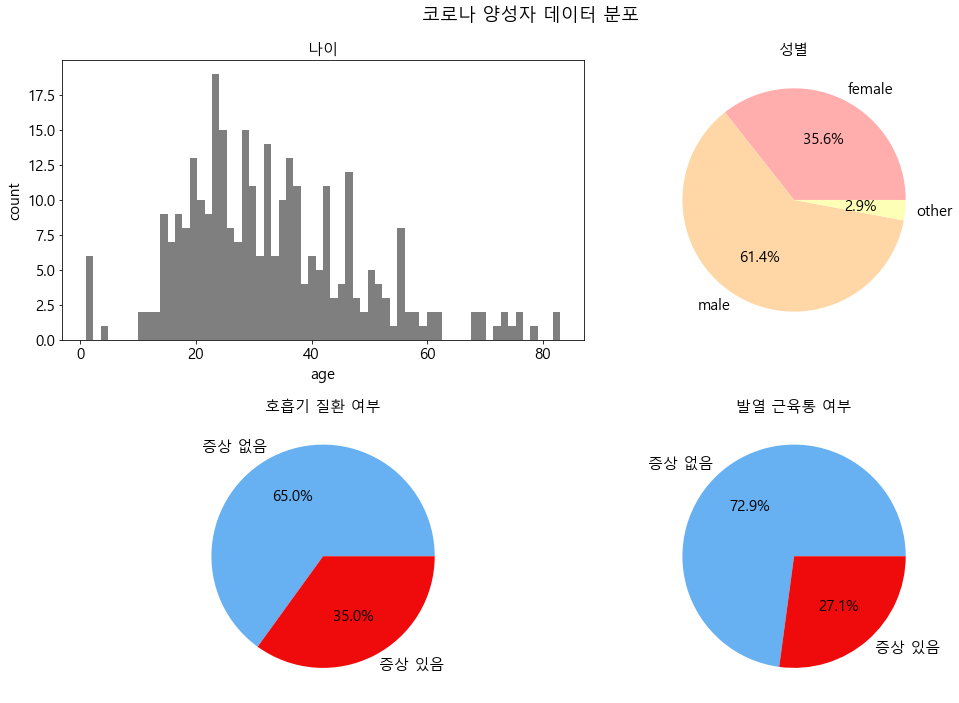

In [23]:
def data_covid_plot():
    # bin 개수를 len를 통하여 정함
    a = len(covid_data['age'].unique())
    fig, axs = plt.subplots(2,2,figsize=(15,10))
    fig.suptitle('코로나 양성자 데이터 분포')

    # 나이
    axs[0,0].hist(covid_data['age'],bins=a,alpha=0.5,color='k') # 데이터 설정 
    axs[0,0].set(xlabel='age', ylabel='count') # x, y 축 label
    axs[0,0].set_title('나이',size=15) # 제목
    
    # 성별
    colors = ['#ffadad', '#ffd6a5', '#fdffb6']
    labels = ['female', 'male', 'other']
    axs[0,1].pie(covid_data['gender'].value_counts().sort_index(),colors=colors,labels=labels,autopct="%.1f%%")
    axs[0,1].set_title('성별',size=15) # 제목

    # 호흡기 증상 여부
    colors = ['#67B0F1', '#EF0B0B']
    labels = ['증상 없음', '증상 있음']
    axs[1,0].pie(covid_data['respiratory_condition'].value_counts(),colors=colors,labels=labels,autopct="%.1f%%")
    axs[1,0].set_title('호흡기 질환 여부',size=15) # 제목
    
    # 발열 혹은 근육통 증상 여부
    colors = ['#67B0F1', '#EF0B0B']
    labels = ['증상 없음', '증상 있음']
    axs[1,1].pie(covid_data['fever_or_muscle_pain'].value_counts(),colors=colors,labels=labels,autopct="%.1f%%")
    axs[1,1].set_title('발열 근육통 여부',size=15) # 제목

    fig.tight_layout()
    plt.show()
    
data_covid_plot()

코로나 | 호흡기 질환 여부 | 발열 근육통 질환 여부
---|---|---
양성 | 14.5% | 35.0%
음성 | 8.5% | 27.1%

- 코로나 양성시 증상이 더 발현되는 것을 볼 수 있습니다.

## 나이별, 성별로 나누어 분석

- 코로나19는 나이대, 성별에 따라 증상발현이 다를 수 있습니다.
- 이에 나이대, 성별을 나누어 조사합니다.
    - 0 ~ 19, 20 ~ 29, 30 ~ 39, 40 ~ 49, 50 ~ 59, 60 ~ 

In [24]:
# 나이가 19이하, 성별이 여자일 경우
def data_0_19_f():
    data_0_19_f = data1[(data1['age'] <= 19) & (data1['gender']==0)] 
    data_0_19_f.reset_index(drop=True,inplace=True)
    return data_0_19_f
data_0_19_f()

age  gender  respiratory_condition  fever_or_muscle_pain  covid19
0     12       0                      0                     1        1
1     17       0                      0                     0        0
2      1       0                      1                     1        0
3      8       0                      1                     0        0
4     16       0                      0                     0        0
..   ...     ...                    ...                   ...      ...
108   18       0                      0                     0        1
109   14       0                      0                     0        0
110   14       0                      0                     0        0
111   18       0                      1                     0        0
112   17       0                      0                     0        0

[113 rows x 5 columns]

In [25]:
# 나이가 19이하, 성별이 남자일 경우
def data_0_19_m():
    data_0_19_m = data1[(data1['age'] <= 19) & (data1['gender']==1)] 
    data_0_19_m.reset_index(drop=True,inplace=True)
    return data_0_19_m
data_0_19_m()

age  gender  respiratory_condition  fever_or_muscle_pain  covid19
0     14       1                      0                     0        0
1     18       1                      0                     0        0
2     14       1                      0                     0        0
3     19       1                      1                     0        1
4      2       1                      0                     0        1
..   ...     ...                    ...                   ...      ...
232   16       1                      0                     0        0
233   15       1                      1                     0        0
234   18       1                      0                     1        0
235   17       1                      0                     0        1
236   18       1                      0                     0        0

[237 rows x 5 columns]

In [26]:
# 나이가 20이상 29이하, 성별이 여자일 경우
def data_20_29_f():
    data_20_29_f = data1[(data1['age'] >= 20)&(data1['age'] <= 29) & (data1['gender']==0)] 
    data_20_29_f.reset_index(drop=True,inplace=True)
    return data_20_29_f
data_20_29_f()

age  gender  respiratory_condition  fever_or_muscle_pain  covid19
0     24       0                      0                     1        0
1     29       0                      1                     0        0
2     24       0                      1                     0        0
3     24       0                      0                     0        1
4     23       0                      0                     0        0
..   ...     ...                    ...                   ...      ...
274   20       0                      0                     0        0
275   20       0                      0                     0        0
276   26       0                      0                     0        0
277   26       0                      0                     0        0
278   27       0                      0                     0        0

[279 rows x 5 columns]

In [27]:
# 나이가 20이상 29이하, 성별이 남자일 경우
def data_20_29_m():
    data_20_29_m = data1[(data1['age'] >= 20)&(data1['age'] <= 29) & (data1['gender']==1)] 
    data_20_29_m.reset_index(drop=True,inplace=True)
    return data_20_29_m
data_20_29_m()

age  gender  respiratory_condition  fever_or_muscle_pain  covid19
0     22       1                      0                     0        0
1     23       1                      0                     0        0
2     29       1                      0                     0        0
3     24       1                      0                     0        0
4     22       1                      0                     0        0
..   ...     ...                    ...                   ...      ...
704   29       1                      0                     0        0
705   22       1                      0                     0        0
706   21       1                      0                     0        0
707   28       1                      0                     0        0
708   25       1                      0                     0        0

[709 rows x 5 columns]

In [28]:
# 나이가 30이상 39이하, 성별이 여자일 경우
def data_30_39_f():
    data_30_39_f = data1[(data1['age'] >= 30)&(data1['age'] <= 39) & (data1['gender']==0)] 
    data_30_39_f.reset_index(drop=True,inplace=True)
    return data_30_39_f
data_30_39_f()

age  gender  respiratory_condition  fever_or_muscle_pain  covid19
0     31       0                      1                     0        1
1     30       0                      0                     0        0
2     36       0                      0                     0        0
3     38       0                      0                     0        0
4     30       0                      0                     1        1
..   ...     ...                    ...                   ...      ...
266   32       0                      0                     0        0
267   33       0                      0                     0        0
268   38       0                      0                     1        0
269   34       0                      0                     0        0
270   32       0                      0                     0        0

[271 rows x 5 columns]

In [29]:
# 나이가 30이상 39이하, 성별이 남자일 경우
def data_30_39_m():
    data_30_39_m = data1[(data1['age'] >= 30)&(data1['age'] <= 39) & (data1['gender']==1)] 
    data_30_39_m.reset_index(drop=True,inplace=True)
    return data_30_39_m
data_30_39_m()

age  gender  respiratory_condition  fever_or_muscle_pain  covid19
0     33       1                      0                     0        1
1     30       1                      0                     0        1
2     39       1                      0                     0        0
3     33       1                      0                     0        0
4     37       1                      0                     0        0
..   ...     ...                    ...                   ...      ...
673   34       1                      0                     0        1
674   33       1                      0                     0        0
675   39       1                      0                     0        0
676   36       1                      0                     0        0
677   34       1                      0                     0        0

[678 rows x 5 columns]

In [30]:
# 나이가 40이상 49이하, 성별이 여자일 경우
def data_40_49_f():
    data_40_49_f = data1[(data1['age'] >= 40)&(data1['age'] <= 49) & (data1['gender']==0)] 
    data_40_49_f.reset_index(drop=True,inplace=True)
    return data_40_49_f
data_40_49_f()

age  gender  respiratory_condition  fever_or_muscle_pain  covid19
0     46       0                      0                     0        0
1     43       0                      0                     0        0
2     40       0                      0                     0        0
3     45       0                      0                     0        0
4     46       0                      0                     0        0
..   ...     ...                    ...                   ...      ...
231   41       0                      0                     0        0
232   44       0                      0                     0        0
233   48       0                      0                     0        0
234   40       0                      0                     0        0
235   49       0                      1                     1        0

[236 rows x 5 columns]

In [31]:
# 나이가 40이상 49이하, 성별이 남자일 경우
def data_40_49_m():
    data_40_49_m = data1[(data1['age'] >= 40)&(data1['age'] <= 49) & (data1['gender']==1)] 
    data_40_49_m.reset_index(drop=True,inplace=True)
    return data_40_49_m
data_40_49_m()

age  gender  respiratory_condition  fever_or_muscle_pain  covid19
0     42       1                      0                     0        0
1     45       1                      0                     0        0
2     49       1                      1                     0        0
3     42       1                      1                     0        1
4     40       1                      0                     0        0
..   ...     ...                    ...                   ...      ...
521   48       1                      0                     1        0
522   44       1                      0                     0        0
523   48       1                      0                     0        0
524   40       1                      0                     0        0
525   46       1                      0                     0        0

[526 rows x 5 columns]

In [32]:
# 나이가 50이상 59이하, 성별이 여자일 경우
def data_50_59_f():
    data_50_59_f = data1[(data1['age'] >= 50)&(data1['age'] <= 59) & (data1['gender']==0)] 
    data_50_59_f.reset_index(drop=True,inplace=True)
    return data_50_59_f
data_50_59_f()

age  gender  respiratory_condition  fever_or_muscle_pain  covid19
0     55       0                      1                     0        0
1     53       0                      1                     0        0
2     53       0                      1                     0        0
3     50       0                      0                     0        0
4     51       0                      1                     0        0
..   ...     ...                    ...                   ...      ...
148   52       0                      0                     0        0
149   55       0                      0                     0        0
150   50       0                      1                     0        0
151   59       0                      0                     0        0
152   51       0                      0                     0        0

[153 rows x 5 columns]

In [33]:
# 나이가 50이상 59이하, 성별이 남자일 경우
def data_50_59_m():
    data_50_59_m = data1[(data1['age'] >= 50)&(data1['age'] <= 59) & (data1['gender']==1)] 
    data_50_59_m.reset_index(drop=True,inplace=True)
    return data_50_59_m
data_50_59_m()

age  gender  respiratory_condition  fever_or_muscle_pain  covid19
0     51       1                      0                     0        0
1     50       1                      0                     0        0
2     59       1                      0                     0        0
3     57       1                      0                     0        0
4     57       1                      0                     0        0
..   ...     ...                    ...                   ...      ...
266   57       1                      0                     0        0
267   53       1                      1                     0        0
268   51       1                      0                     0        0
269   55       1                      0                     0        0
270   53       1                      0                     0        0

[271 rows x 5 columns]

In [34]:
# 나이가 60이상, 성별이 여자일 경우
def data_60_f():
    data_60_f = data1[(data1['age'] >= 60)&  (data1['gender']==0)] 
    data_60_f.reset_index(drop=True,inplace=True)
    return data_60_f
data_60_f()

age  gender  respiratory_condition  fever_or_muscle_pain  covid19
0     73       0                      0                     0        0
1     61       0                      0                     0        0
2     77       0                      0                     0        0
3     73       0                      0                     0        0
4     61       0                      0                     0        0
..   ...     ...                    ...                   ...      ...
116   64       0                      0                     0        0
117   65       0                      0                     0        0
118   63       0                      1                     0        0
119   62       0                      0                     0        0
120   60       0                      0                     0        0

[121 rows x 5 columns]

In [35]:
# 나이가 60이상, 성별이 남자일 경우
def data_60_m():
    data_60_m = data1[(data1['age'] >= 60)&  (data1['gender']==1)] 
    data_60_m.reset_index(drop=True,inplace=True)
    return data_60_m
data_60_m()

age  gender  respiratory_condition  fever_or_muscle_pain  covid19
0     68       1                      0                     0        0
1     62       1                      0                     0        0
2     62       1                      0                     0        0
3     82       1                      0                     0        0
4     62       1                      0                     0        0
..   ...     ...                    ...                   ...      ...
180   74       1                      1                     0        0
181   70       1                      0                     0        0
182   70       1                      0                     0        0
183   82       1                      0                     0        0
184   83       1                      1                     0        0

[185 rows x 5 columns]

In [36]:
# 변수를 선언합니다.
data_0_19_f = data_0_19_f()
data_0_19_m = data_0_19_m()
data_20_29_f = data_20_29_f()
data_20_29_m = data_20_29_m()
data_30_39_f = data_30_39_f()
data_30_39_m = data_30_39_m()
data_40_49_f = data_40_49_f()
data_40_49_m = data_40_49_m()
data_50_59_f = data_50_59_f()
data_50_59_m = data_50_59_m()
data_60_f = data_60_f()
data_60_m = data_60_m()

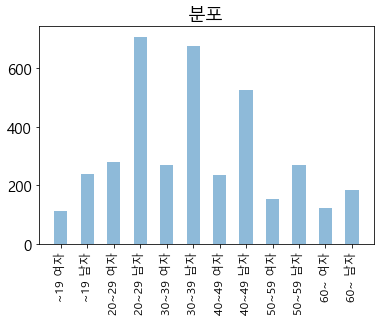

In [37]:
# 각 나이별, 성별로 분포를 확인합니다.
labels = ['~19 여자', '~19 남자', '20~29 여자', '20~29 남자', '30~39 여자', '30~39 남자', '40~49 여자', '40~49 남자', '50~59 여자', '50~59 남자', '60~ 여자', '60~ 남자']
values = [len(data_0_19_f),len(data_0_19_m),len(data_20_29_f),len(data_20_29_m),len(data_30_39_f),len(data_30_39_m),len(data_40_49_f),len(data_40_49_m),len(data_50_59_f),len(data_50_59_m),len(data_60_f),len(data_60_m)]
plt.bar(labels,values,width=0.5,alpha=0.5)
plt.xticks(rotation=90,size=12)
plt.title('분포')
plt.show()

- 나이별, 성별로 분포를 확인하였으면 이제 나이별로 분포를 확인합니다.

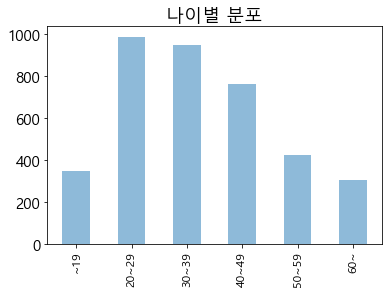

In [38]:
labels = ['~19', '20~29', '30~39', '40~49', '50~59', '60~']
values = [len(data_0_19_f)+len(data_0_19_m),len(data_20_29_f)+len(data_20_29_m),len(data_30_39_f)+len(data_30_39_m),len(data_40_49_f)+len(data_40_49_m),len(data_50_59_f)+len(data_50_59_m),len(data_60_f)+len(data_60_m)]
plt.bar(labels,values,width=0.5,alpha=0.5)
plt.xticks(rotation=90,size=12)
plt.title('나이별 분포')
plt.show()

- 20대가 많은 것을 볼 수 있습니다.

- 이제 나이별, 성별로 증상, 코로나 양성 여부를 확인해 보겠습니다.

In [39]:
def plot_age_gender(data,title):
    fig, axs = plt.subplots(2,2,figsize=(15,10))
    fig.suptitle('{}'.format(title))

    # 호흡기 증상 여부
    colors = ['#67B0F1', '#EF0B0B']
    labels = ['증상 없음', '증상 있음']
    axs[0,0].pie(data['respiratory_condition'].value_counts(),colors=colors,labels=labels,autopct="%.1f%%")
    axs[0,0].set_title('호흡기 질환 여부',size=15) # 제목
    
    # 발열 혹은 근육통 증상 여부
    colors = ['#67B0F1', '#EF0B0B']
    labels = ['증상 없음', '증상 있음']
    axs[0,1].pie(data['fever_or_muscle_pain'].value_counts(),colors=colors,labels=labels,autopct="%.1f%%")
    axs[0,1].set_title('발열 근육통 여부',size=15) # 제목

    # 코로나 양성 여부
    colors = ['#67B0F1', '#EF0B0B']
    labels = ['음성', '양성']
    axs[1,0].pie(data['covid19'].value_counts(),colors=colors,labels=labels,autopct="%.1f%%")
    axs[1,0].set_title('코로나 양성',size=15) # 제목
    
    fig.delaxes(axs[1][1])
    fig.tight_layout()
    plt.show()

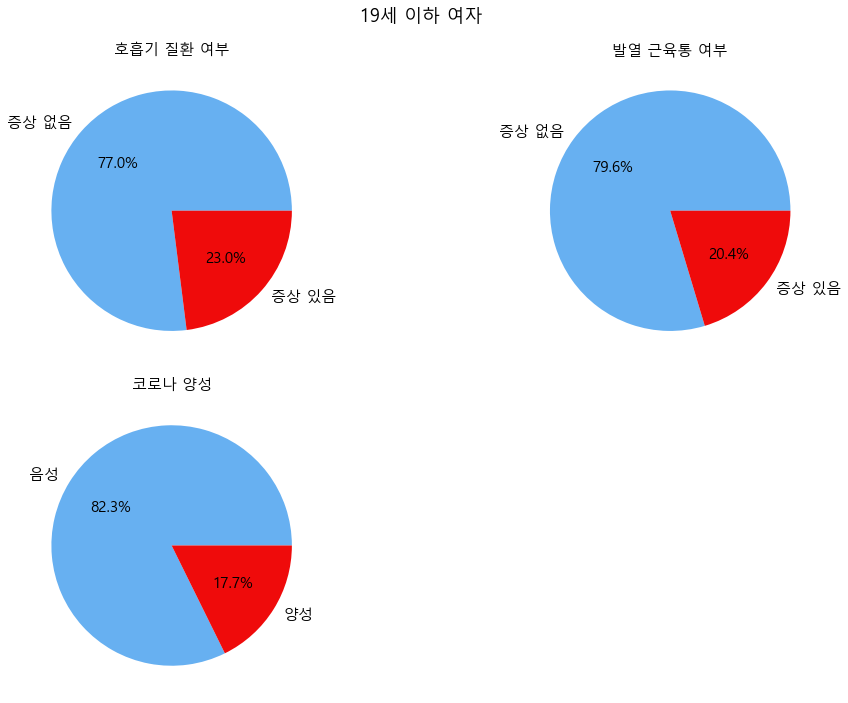

In [40]:
# 19세 이하 여자
plot_age_gender(data_0_19_f,'19세 이하 여자')

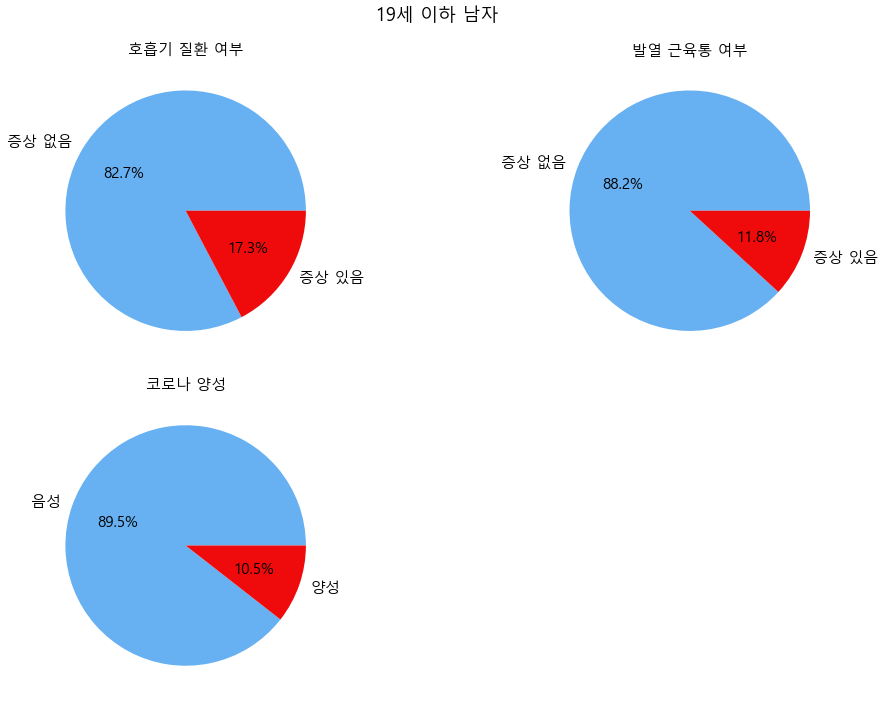

In [41]:
# 19세 이하 남자
plot_age_gender(data_0_19_m,'19세 이하 남자')

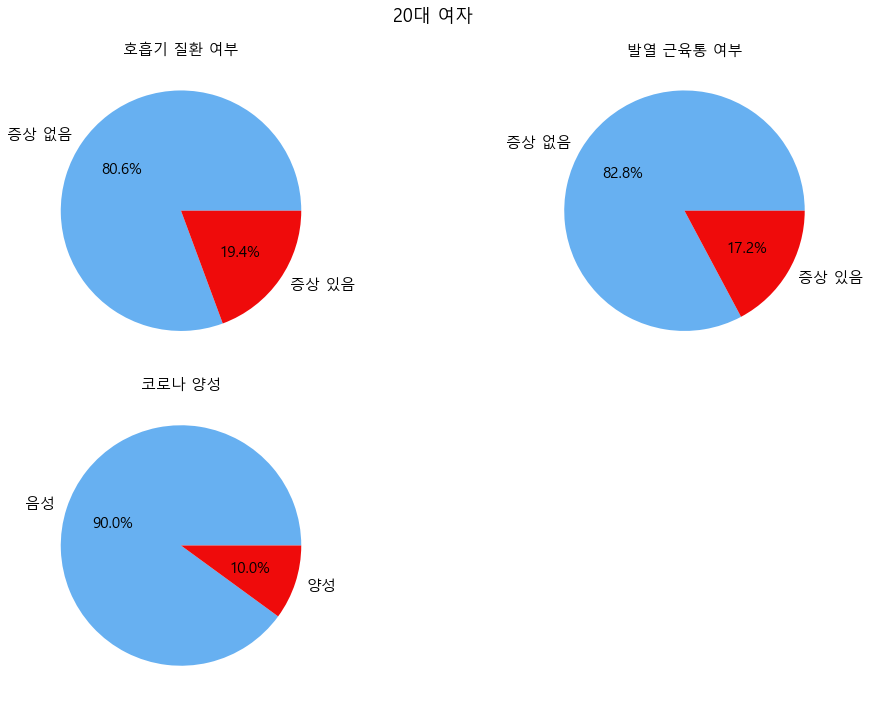

In [42]:
# 20대 여자
plot_age_gender(data_20_29_f,'20대 여자')

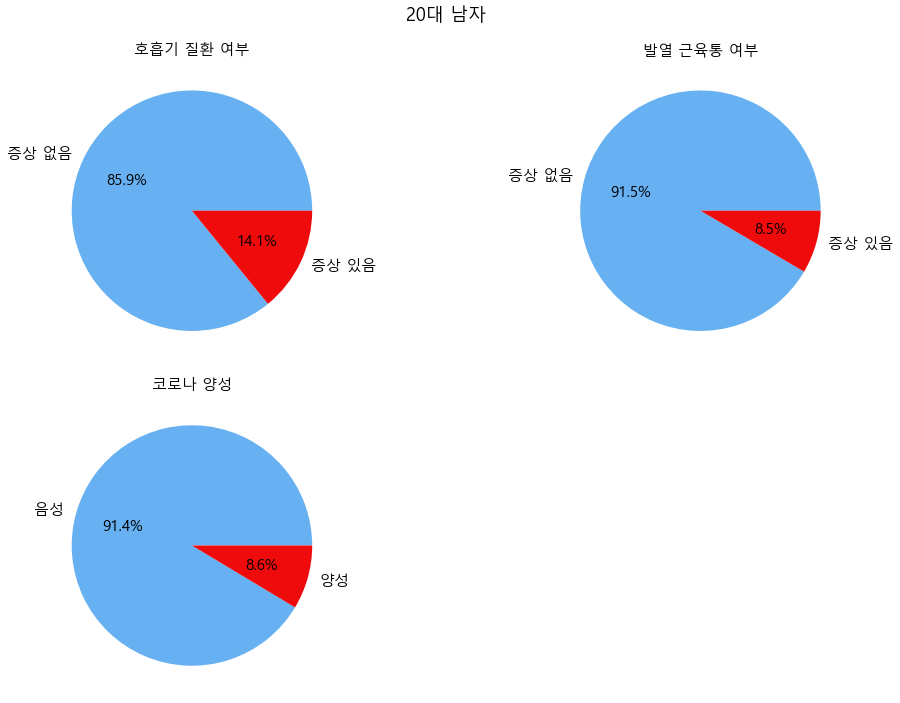

In [43]:
# 20대 남자
plot_age_gender(data_20_29_m,'20대 남자')

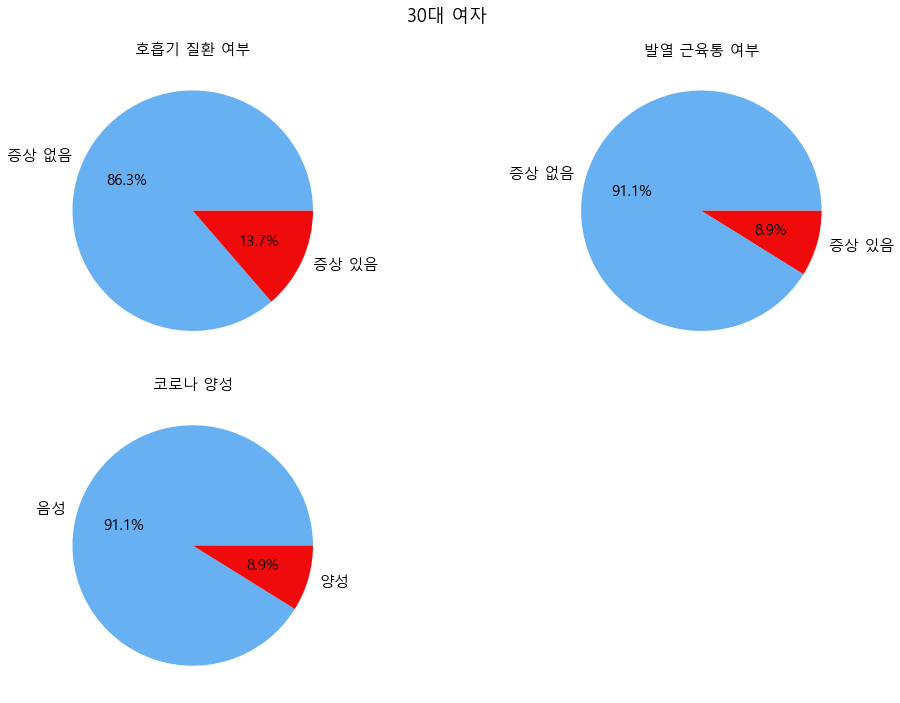

In [44]:
# 30대 여자
plot_age_gender(data_30_39_f,'30대 여자')

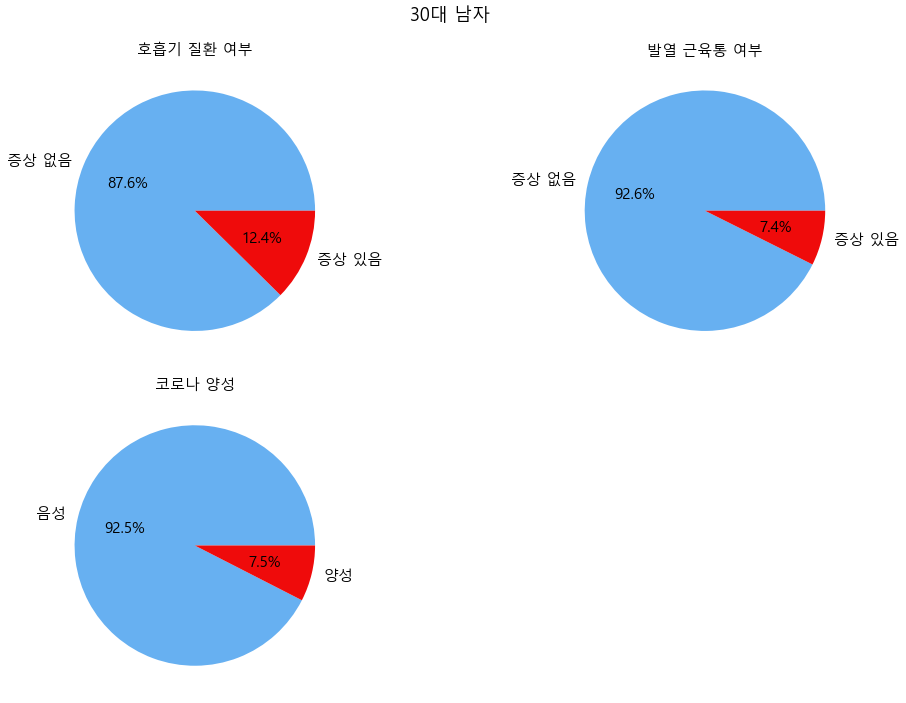

In [45]:
# 30대 남자
plot_age_gender(data_30_39_m,'30대 남자')

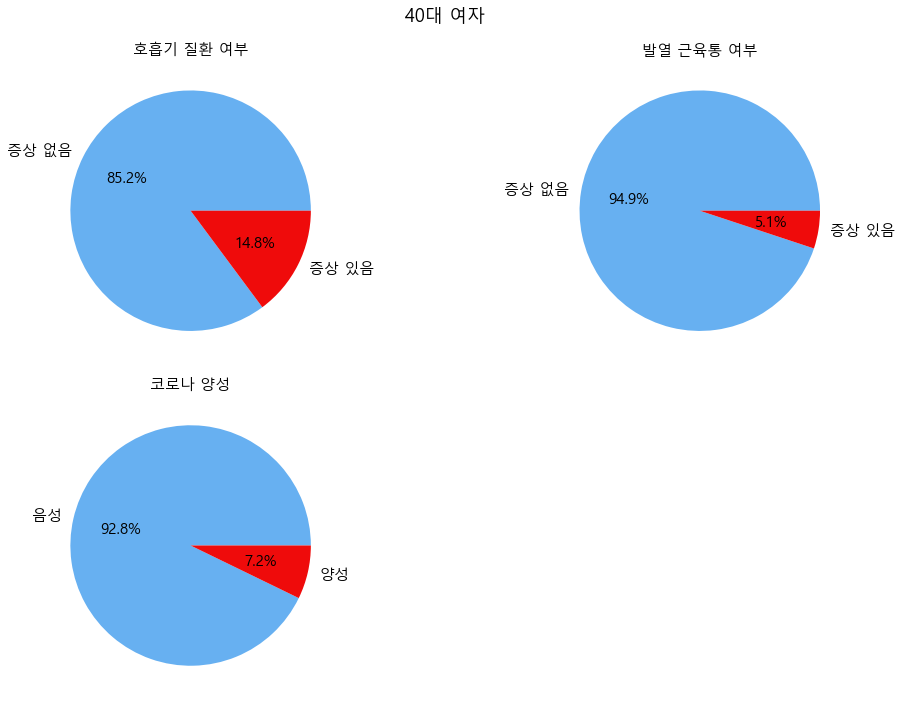

In [46]:
# 40대 여자
plot_age_gender(data_40_49_f,'40대 여자')

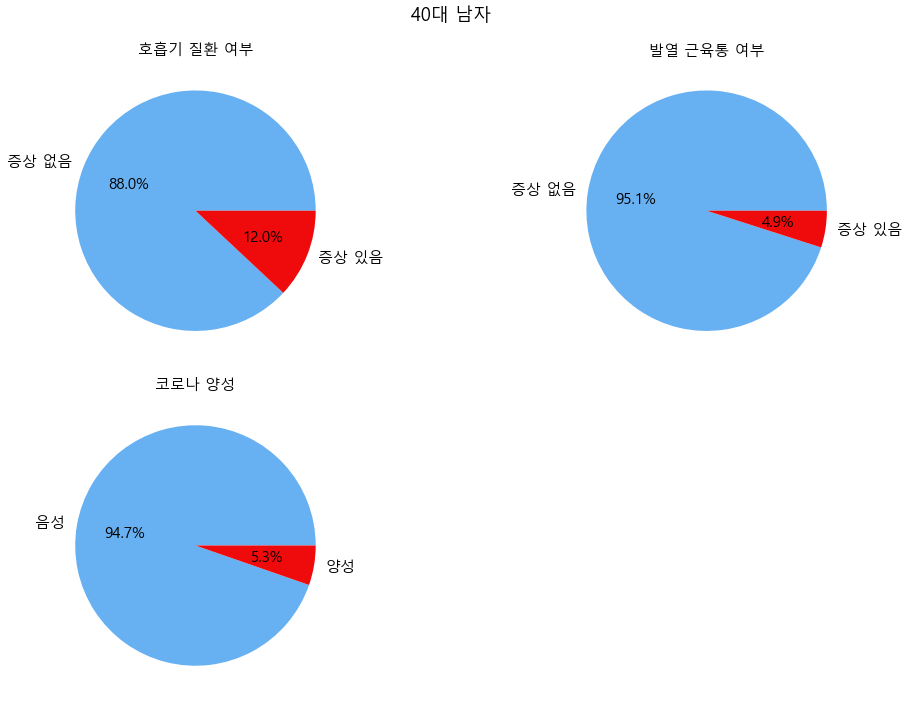

In [47]:
# 40대 남자
plot_age_gender(data_40_49_m,'40대 남자')

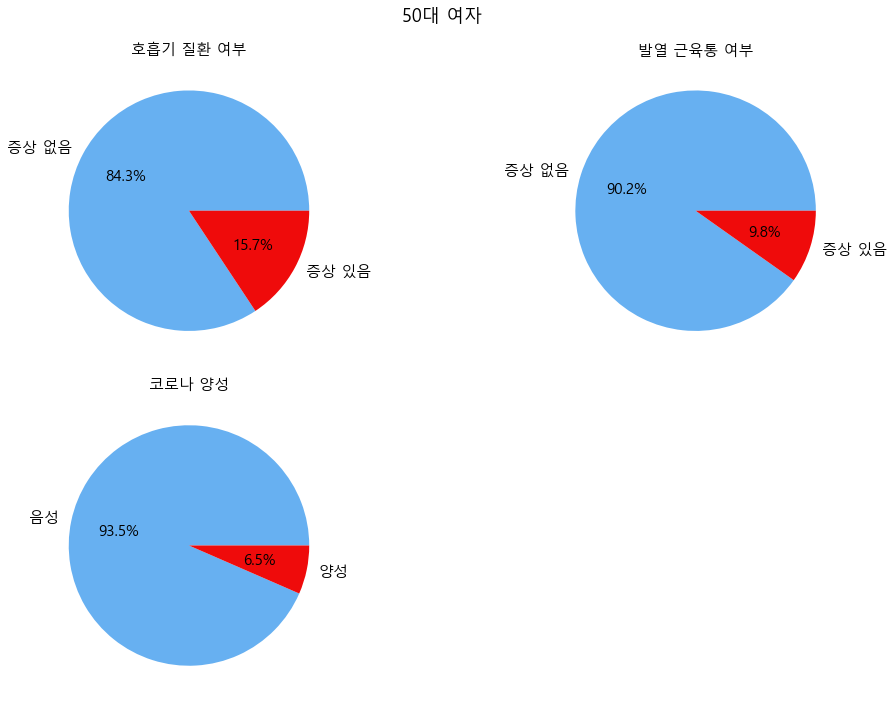

In [48]:
# 50대 여자
plot_age_gender(data_50_59_f,'50대 여자')

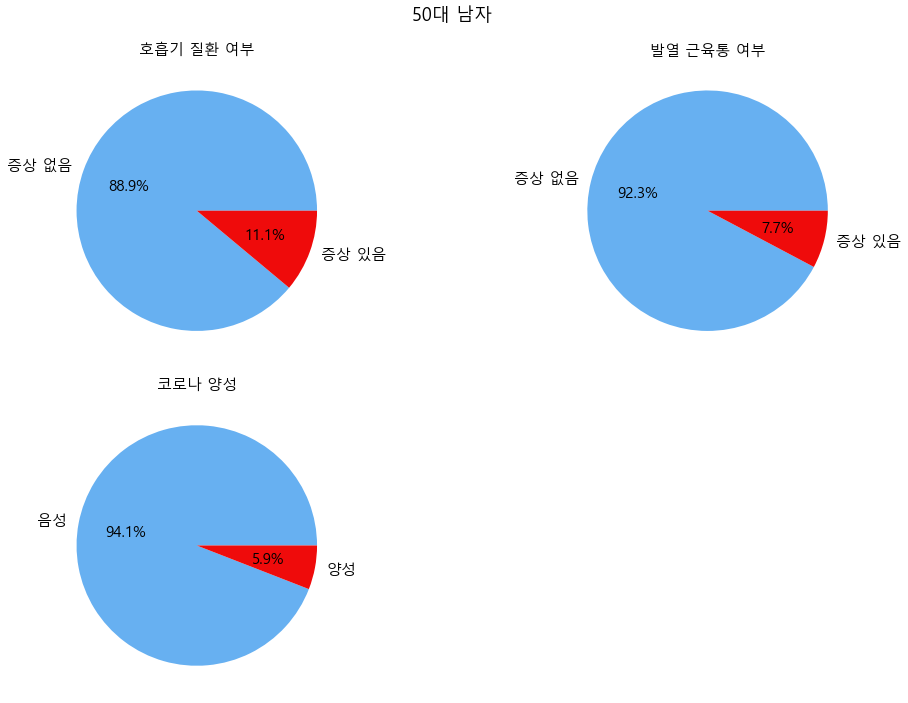

In [49]:
# 50대 남자
plot_age_gender(data_50_59_m,'50대 남자')

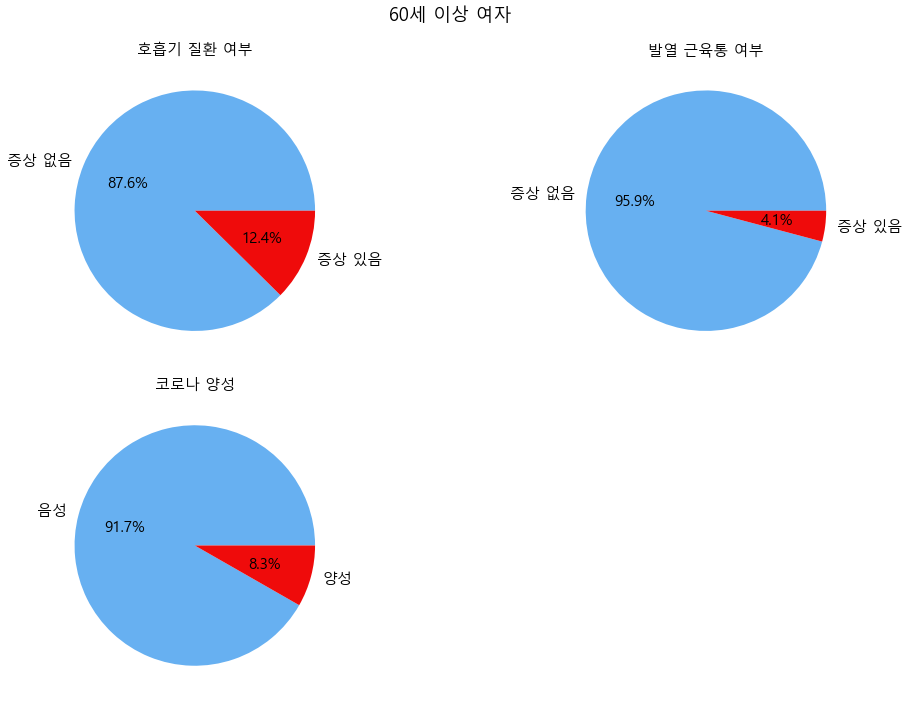

In [50]:
# 60세 이상 여자
plot_age_gender(data_60_f,'60세 이상 여자')

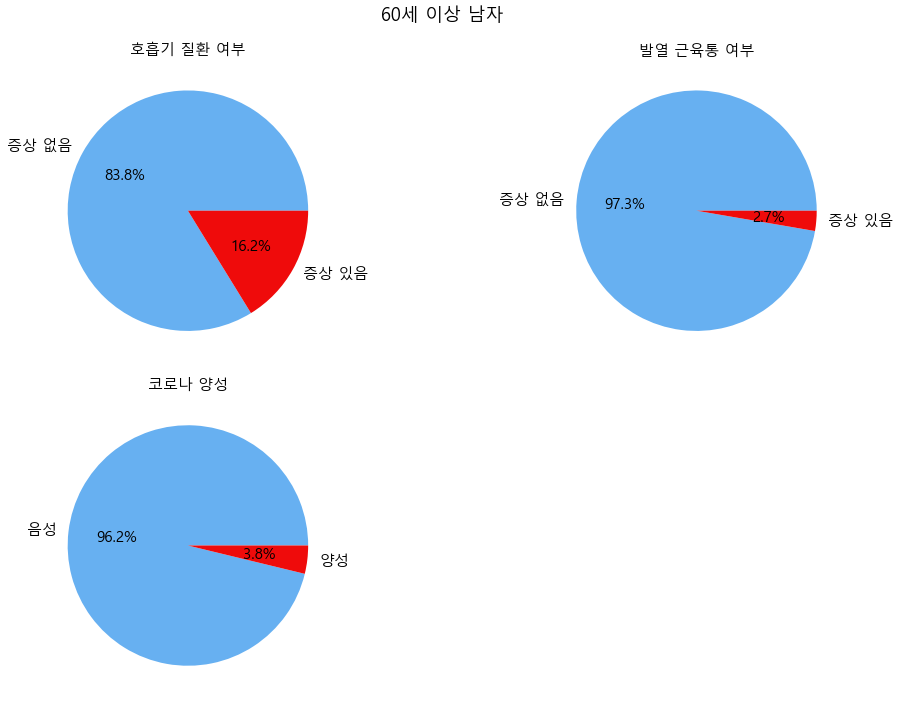

In [51]:
# 60세 이상 남자
plot_age_gender(data_60_m,'60세 이상 남자')

## 상관도 분석

상관도 분석을 통하여 나이, 성별, 호흡기 질환 여부, 발열 근육통 질환 여부가 얼마나 코로나 양성에 상관이 있는지 분석해보겠습니다.

Text(0, 0.5, 'covid19')

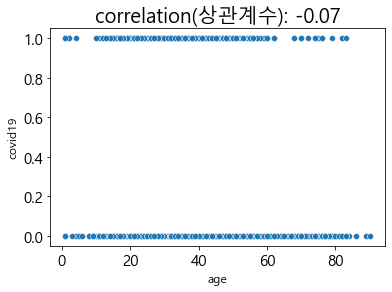

In [52]:
correlation = data1['age'].corr(data1['covid19'])
sns.scatterplot(data1['age'],data1['covid19'])
plt.title('correlation(상관계수): ' + str(np.round(correlation,2)), fontsize=20)
plt.xlabel('age',fontsize=12)
plt.ylabel('covid19', fontsize=12)

Text(0, 0.5, 'covid19')

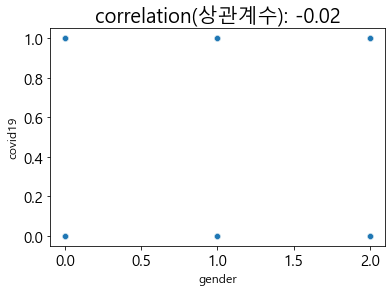

In [53]:
correlation = data1['gender'].corr(data1['covid19'])
sns.scatterplot(data1['gender'],data1['covid19'])
plt.title('correlation(상관계수): ' + str(np.round(correlation,2)), fontsize=20)
plt.xlabel('gender',fontsize=12)
plt.ylabel('covid19', fontsize=12)

Text(0, 0.5, 'covid19')

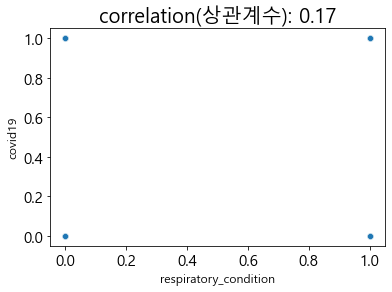

In [54]:
correlation = data1['respiratory_condition'].corr(data1['covid19'])
sns.scatterplot(data1['respiratory_condition'],data1['covid19'])
plt.title('correlation(상관계수): ' + str(np.round(correlation,2)), fontsize=20)
plt.xlabel('respiratory_condition',fontsize=12)
plt.ylabel('covid19', fontsize=12)

Text(0, 0.5, 'covid19')

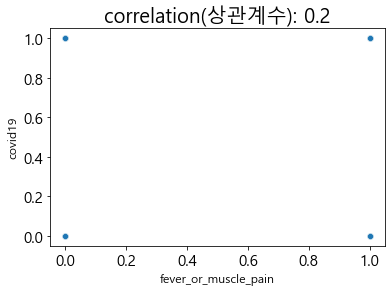

In [55]:
correlation = data1['fever_or_muscle_pain'].corr(data1['covid19'])
sns.scatterplot(data1['fever_or_muscle_pain'],data1['covid19'])
plt.title('correlation(상관계수): ' + str(np.round(correlation,2)), fontsize=20)
plt.xlabel('fever_or_muscle_pain',fontsize=12)
plt.ylabel('covid19', fontsize=12)

- 비선형적인 그래프를 보이고 상관계수가 매우 낮은 것을 볼 수 있습니다.

- 이제 나이별, 성별로 코로나 양성 여부의 상관도를 확인해봅니다.

In [56]:
data_0_19_f.drop(columns=['gender']).corr().iloc[:,3]

age                     -0.123571
respiratory_condition    0.242300
fever_or_muscle_pain     0.399043
covid19                  1.000000
Name: covid19, dtype: float64

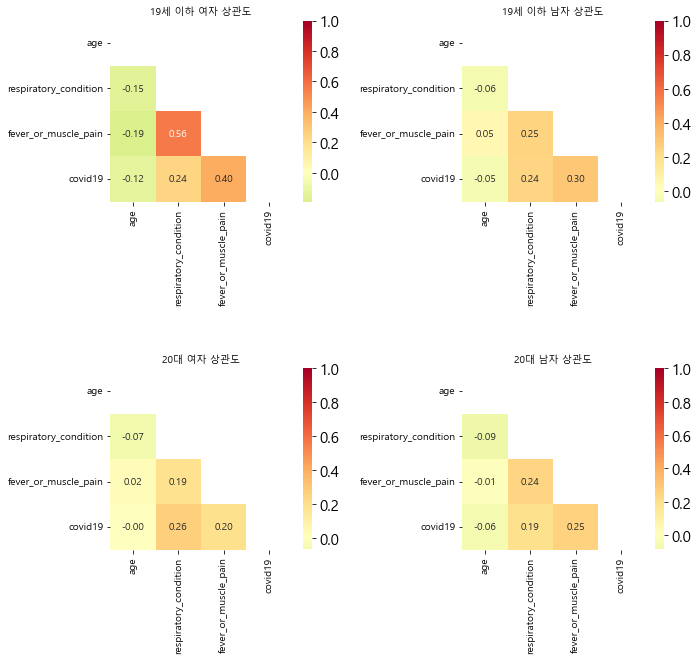

In [57]:
# 19세 이하 ~ 20대 상관도
f, axs = plt.subplots(2,2,figsize=(10,10))
mask = np.zeros_like(data_0_19_f.drop(columns=['gender']).corr(),dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
g = sns.heatmap(data_0_19_f.drop(columns=['gender']).corr(),cmap='RdYlGn_r',
                vmax=1,mask=mask,center=0,annot=True,annot_kws={"size": 10},fmt='.2f',square=True,ax=axs[0,0],cbar_kws={'shrink':.7})
g.set_xticklabels(g.get_xmajorticklabels(),fontsize=10)
g.set_yticklabels(g.get_xmajorticklabels(),fontsize=10)

axs[0,0].set_title('19세 이하 여자 상관도',size=10)

mask = np.zeros_like(data_0_19_m.drop(columns=['gender']).corr(),dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
g = sns.heatmap(data_0_19_m.drop(columns=['gender']).corr(),cmap='RdYlGn_r',
                vmax=1,mask=mask,center=0,annot=True,annot_kws={"size": 10},fmt='.2f',square=True,ax=axs[0,1],cbar_kws={'shrink':.7})
g.set_xticklabels(g.get_xmajorticklabels(),fontsize=10)
g.set_yticklabels(g.get_xmajorticklabels(),fontsize=10)

axs[0,1].set_title('19세 이하 남자 상관도',size=10)

mask = np.zeros_like(data_20_29_f.drop(columns=['gender']).corr(),dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
g = sns.heatmap(data_20_29_f.drop(columns=['gender']).corr(),cmap='RdYlGn_r',
                vmax=1,mask=mask,center=0,annot=True,annot_kws={"size": 10},fmt='.2f',square=True,ax=axs[1,0],cbar_kws={'shrink':.7})
g.set_xticklabels(g.get_xmajorticklabels(),fontsize=10)
g.set_yticklabels(g.get_xmajorticklabels(),fontsize=10)

axs[1,0].set_title('20대 여자 상관도',size=10)

mask = np.zeros_like(data_20_29_m.drop(columns=['gender']).corr(),dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
g = sns.heatmap(data_20_29_m.drop(columns=['gender']).corr(),cmap='RdYlGn_r',
                vmax=1,mask=mask,center=0,annot=True,annot_kws={"size": 10},fmt='.2f',square=True,ax=axs[1,1],cbar_kws={'shrink':.7})
g.set_xticklabels(g.get_xmajorticklabels(),fontsize=10)
g.set_yticklabels(g.get_xmajorticklabels(),fontsize=10)

axs[1,1].set_title('20대 남자 상관도',size=10)

plt.tight_layout()
plt.show()

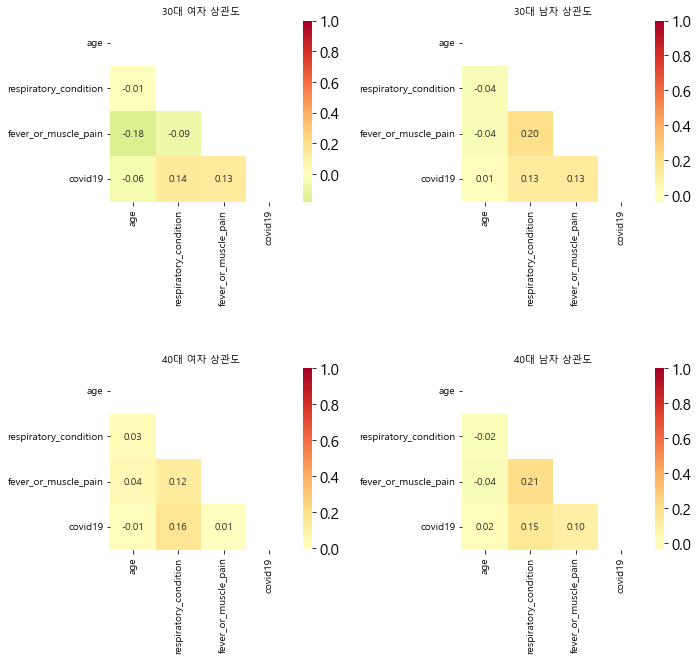

In [58]:
# 30대, 40대 상관도
f, axs = plt.subplots(2,2,figsize=(10,10))
mask = np.zeros_like(data_30_39_f.drop(columns=['gender']).corr(),dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
g = sns.heatmap(data_30_39_f.drop(columns=['gender']).corr(),cmap='RdYlGn_r',
                vmax=1,mask=mask,center=0,annot=True,annot_kws={"size": 10},fmt='.2f',square=True,ax=axs[0,0],cbar_kws={'shrink':.7})
g.set_xticklabels(g.get_xmajorticklabels(),fontsize=10)
g.set_yticklabels(g.get_xmajorticklabels(),fontsize=10)

axs[0,0].set_title('30대 여자 상관도',size=10)

mask = np.zeros_like(data_30_39_m.drop(columns=['gender']).corr(),dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
g = sns.heatmap(data_30_39_m.drop(columns=['gender']).corr(),cmap='RdYlGn_r',
                vmax=1,mask=mask,center=0,annot=True,annot_kws={"size": 10},fmt='.2f',square=True,ax=axs[0,1],cbar_kws={'shrink':.7})
g.set_xticklabels(g.get_xmajorticklabels(),fontsize=10)
g.set_yticklabels(g.get_xmajorticklabels(),fontsize=10)

axs[0,1].set_title('30대 남자 상관도',size=10)

mask = np.zeros_like(data_40_49_f.drop(columns=['gender']).corr(),dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
g = sns.heatmap(data_40_49_f.drop(columns=['gender']).corr(),cmap='RdYlGn_r',
                vmax=1,mask=mask,center=0,annot=True,annot_kws={"size": 10},fmt='.2f',square=True,ax=axs[1,0],cbar_kws={'shrink':.7})
g.set_xticklabels(g.get_xmajorticklabels(),fontsize=10)
g.set_yticklabels(g.get_xmajorticklabels(),fontsize=10)

axs[1,0].set_title('40대 여자 상관도',size=10)

mask = np.zeros_like(data_40_49_m.drop(columns=['gender']).corr(),dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
g = sns.heatmap(data_40_49_m.drop(columns=['gender']).corr(),cmap='RdYlGn_r',
                vmax=1,mask=mask,center=0,annot=True,annot_kws={"size": 10},fmt='.2f',square=True,ax=axs[1,1],cbar_kws={'shrink':.7})
g.set_xticklabels(g.get_xmajorticklabels(),fontsize=10)
g.set_yticklabels(g.get_xmajorticklabels(),fontsize=10)

axs[1,1].set_title('40대 남자 상관도',size=10)

plt.tight_layout()
plt.show()

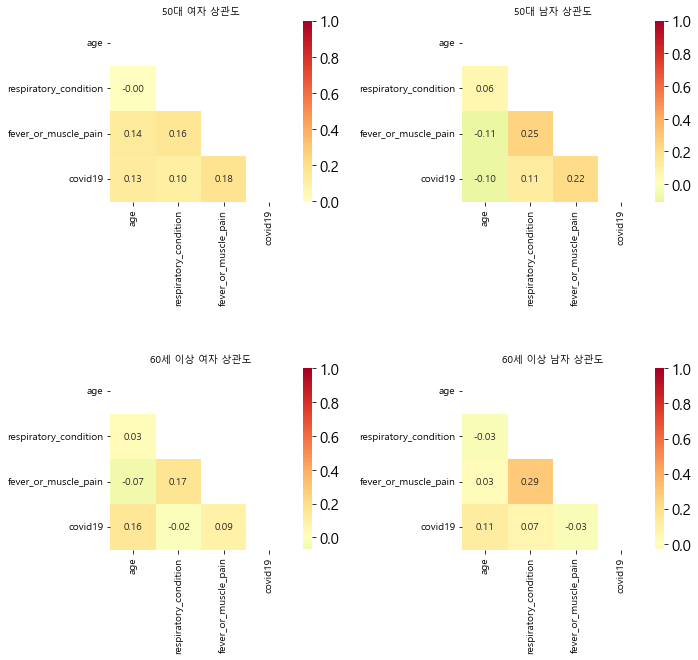

In [59]:
# 50대, 60세 이상 상관도
f, axs = plt.subplots(2,2,figsize=(10,10))
mask = np.zeros_like(data_50_59_f.drop(columns=['gender']).corr(),dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
g = sns.heatmap(data_50_59_f.drop(columns=['gender']).corr(),cmap='RdYlGn_r',
                vmax=1,mask=mask,center=0,annot=True,annot_kws={"size": 10},fmt='.2f',square=True,ax=axs[0,0],cbar_kws={'shrink':.7})
g.set_xticklabels(g.get_xmajorticklabels(),fontsize=10)
g.set_yticklabels(g.get_xmajorticklabels(),fontsize=10)

axs[0,0].set_title('50대 여자 상관도',size=10)

mask = np.zeros_like(data_50_59_m.drop(columns=['gender']).corr(),dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
g = sns.heatmap(data_50_59_m.drop(columns=['gender']).corr(),cmap='RdYlGn_r',
                vmax=1,mask=mask,center=0,annot=True,annot_kws={"size": 10},fmt='.2f',square=True,ax=axs[0,1],cbar_kws={'shrink':.7})
g.set_xticklabels(g.get_xmajorticklabels(),fontsize=10)
g.set_yticklabels(g.get_xmajorticklabels(),fontsize=10)

axs[0,1].set_title('50대 남자 상관도',size=10)

mask = np.zeros_like(data_60_f.drop(columns=['gender']).corr(),dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
g = sns.heatmap(data_60_f.drop(columns=['gender']).corr(),cmap='RdYlGn_r',
                vmax=1,mask=mask,center=0,annot=True,annot_kws={"size": 10},fmt='.2f',square=True,ax=axs[1,0],cbar_kws={'shrink':.7})
g.set_xticklabels(g.get_xmajorticklabels(),fontsize=10)
g.set_yticklabels(g.get_xmajorticklabels(),fontsize=10)

axs[1,0].set_title('60세 이상 여자 상관도',size=10)

mask = np.zeros_like(data_60_m.drop(columns=['gender']).corr(),dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
g = sns.heatmap(data_60_m.drop(columns=['gender']).corr(),cmap='RdYlGn_r',
                vmax=1,mask=mask,center=0,annot=True,annot_kws={"size": 10},fmt='.2f',square=True,ax=axs[1,1],cbar_kws={'shrink':.7})
g.set_xticklabels(g.get_xmajorticklabels(),fontsize=10)
g.set_yticklabels(g.get_xmajorticklabels(),fontsize=10)

axs[1,1].set_title('60세 이상 남자 상관도',size=10)

plt.tight_layout()
plt.show()

- 전체적으로 상관도가 매우 낮음을 볼 수 있습니다.
- 증상 발현이 코로나 양성 여부에 큰 영향이 없음을 볼 수 있습니다.
---
이제 코로나 양성을 받은 사람들를 분석해보겠습니다

In [60]:
data_0_19_f[data_0_19_f['covid19']==1].reset_index(drop=True)

age  gender  respiratory_condition  fever_or_muscle_pain  covid19
0    12       0                      0                     1        1
1     1       0                      0                     0        1
2    16       0                      0                     0        1
3    17       0                      1                     1        1
4    18       0                      1                     1        1
5    16       0                      1                     1        1
6    18       0                      0                     0        1
7     4       0                      1                     0        1
8     1       0                      0                     0        1
9    16       0                      0                     0        1
10   19       0                      1                     1        1
11   15       0                      0                     1        1
12    1       0                      1                     1        1
13   16       0                      1                     1        1
14   17       0                      0                     0        1
15   12       0                      0                     0        1
16   18       0                      0                     1        1
17   15       0                      1                     1        1
18   18       0                      1                     1        1
19   18       0                      0                     0        1

In [61]:
def plot_covid_age_gender(data,data2,title):
    fig, axs = plt.subplots(2,2,figsize=(10,10))
    fig.suptitle('{}'.format(title))

    # 호흡기 증상 여부
    colors = ['#67B0F1', '#EF0B0B']
    labels = ['증상 없음', '증상 있음']
    axs[0,0].pie(data['respiratory_condition'].value_counts(),colors=colors,labels=labels,autopct="%.1f%%")
    axs[0,0].set_title('호흡기 질환 여부(여자)',size=15) # 제목
    
    # 발열 혹은 근육통 증상 여부
    colors = ['#67B0F1', '#EF0B0B']
    labels = ['증상 없음', '증상 있음']
    axs[0,1].pie(data['fever_or_muscle_pain'].value_counts(),colors=colors,labels=labels,autopct="%.1f%%")
    axs[0,1].set_title('발열 근육통 여부(여자)',size=15) # 제목
    
    # 호흡기 증상 여부
    colors = ['#67B0F1', '#EF0B0B']
    labels = ['증상 없음', '증상 있음']
    axs[1,0].pie(data2['respiratory_condition'].value_counts(),colors=colors,labels=labels,autopct="%.1f%%")
    axs[1,0].set_title('호흡기 질환 여부(남자)',size=15) # 제목
    
    # 발열 혹은 근육통 증상 여부
    colors = ['#67B0F1', '#EF0B0B']
    labels = ['증상 없음', '증상 있음']
    axs[1,1].pie(data2['fever_or_muscle_pain'].value_counts(),colors=colors,labels=labels,autopct="%.1f%%")
    axs[1,1].set_title('발열 근육통 여부(남자)',size=15) # 제목
    
    fig.tight_layout()
    plt.show()

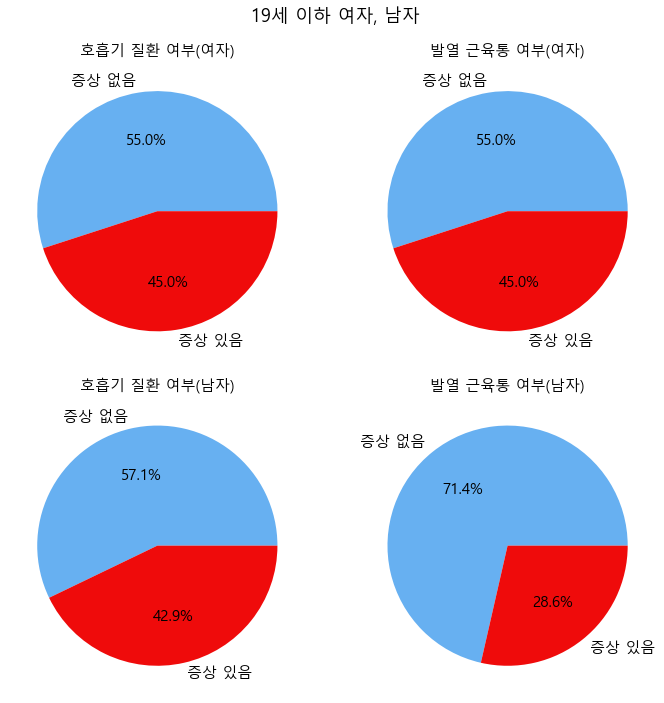

In [62]:
# 19세 이하 
data_covid_0_19_f = (data_0_19_f[data_0_19_f['covid19']==1].reset_index(drop=True))
data_covid_0_19_m = (data_0_19_f[data_0_19_m['covid19']==1].reset_index(drop=True))
plot_covid_age_gender(data_covid_0_19_f,data_covid_0_19_m,'19세 이하 여자, 남자')

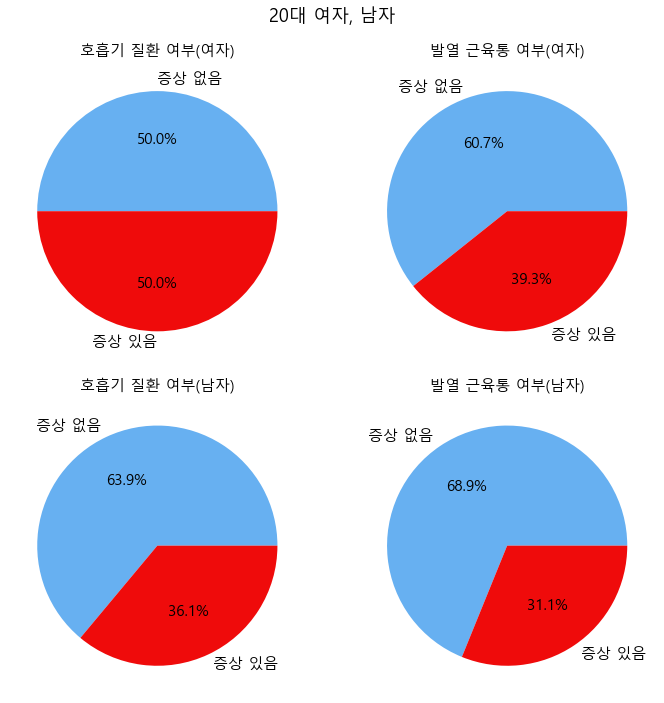

In [63]:
# 20대 
data_covid_20_29_f = (data_20_29_f[data_20_29_f['covid19']==1].reset_index(drop=True))
data_covid_20_29_m = (data_20_29_m[data_20_29_m['covid19']==1].reset_index(drop=True))
plot_covid_age_gender(data_covid_20_29_f,data_covid_20_29_m,'20대 여자, 남자')

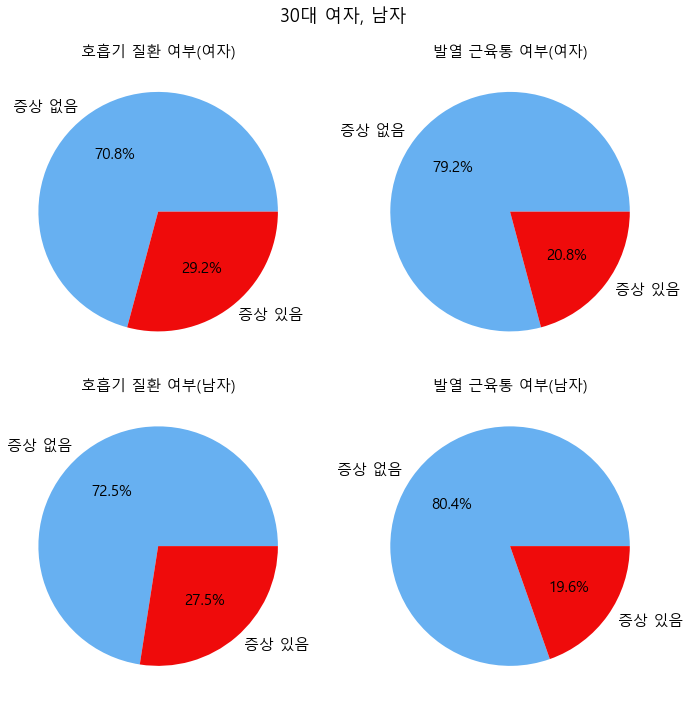

In [64]:
# 30대 
data_covid_30_39_f = (data_30_39_f[data_30_39_f['covid19']==1].reset_index(drop=True))
data_covid_30_39_m = (data_30_39_m[data_30_39_m['covid19']==1].reset_index(drop=True))
plot_covid_age_gender(data_covid_30_39_f,data_covid_30_39_m,'30대 여자, 남자')

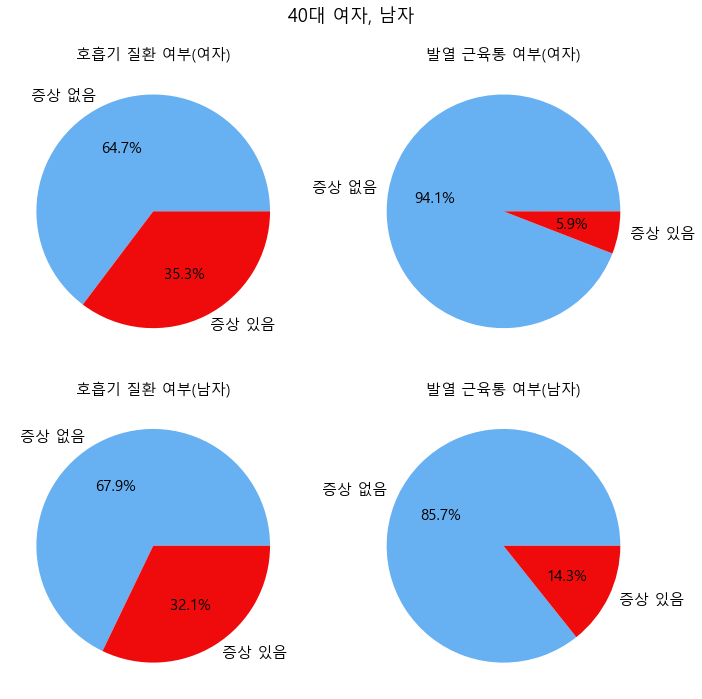

In [65]:
# 40대 
data_covid_40_49_f = (data_40_49_f[data_40_49_f['covid19']==1].reset_index(drop=True))
data_covid_40_49_m = (data_40_49_m[data_40_49_m['covid19']==1].reset_index(drop=True))
plot_covid_age_gender(data_covid_40_49_f,data_covid_40_49_m,'40대 여자, 남자')

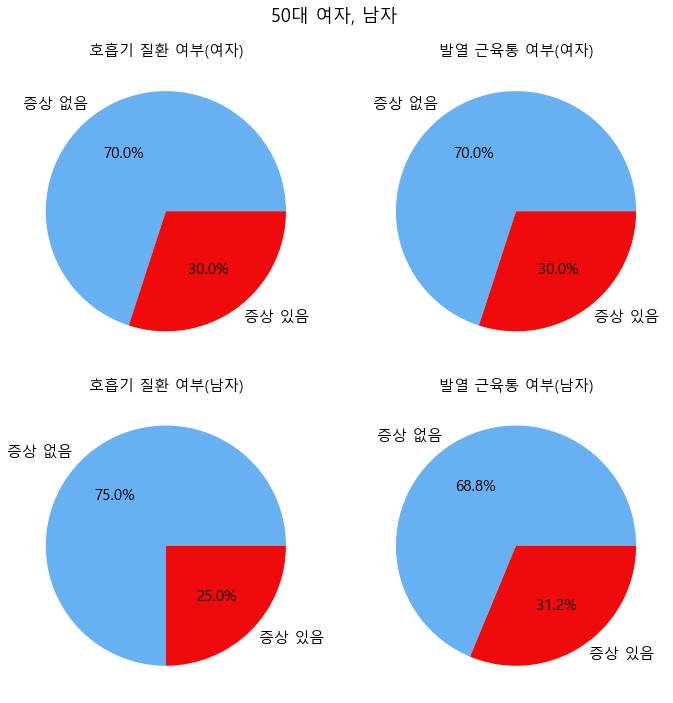

In [66]:
# 50대 
data_covid_50_59_f = (data_50_59_f[data_50_59_f['covid19']==1].reset_index(drop=True))
data_covid_50_59_m = (data_50_59_m[data_50_59_m['covid19']==1].reset_index(drop=True))
plot_covid_age_gender(data_covid_50_59_f,data_covid_50_59_m,'50대 여자, 남자')

- 60세 이상 남자 중 코로나 양성을 받은 사람이 발열과 근육통증을 느끼는 경우는 없습니다.
- 이에 발열, 근육통 발현 그래프는 생략합니다.

In [67]:
def plot_covid_age_gender_50_60(data,data2,title):
    fig, axs = plt.subplots(2,2,figsize=(10,10))
    fig.suptitle('{}'.format(title))

    # 호흡기 증상 여부
    colors = ['#67B0F1', '#EF0B0B']
    labels = ['증상 없음', '증상 있음']
    axs[0,0].pie(data['respiratory_condition'].value_counts(),colors=colors,labels=labels,autopct="%.1f%%")
    axs[0,0].set_title('호흡기 질환 여부(여자)',size=15) # 제목
    
    # 발열 혹은 근육통 증상 여부
    colors = ['#67B0F1', '#EF0B0B']
    labels = ['증상 없음', '증상 있음']
    axs[0,1].pie(data['fever_or_muscle_pain'].value_counts(),colors=colors,labels=labels,autopct="%.1f%%")
    axs[0,1].set_title('발열 근육통 여부(여자)',size=15) # 제목
    
    # 호흡기 증상 여부
    colors = ['#67B0F1', '#EF0B0B']
    labels = ['증상 없음', '증상 있음']
    axs[1,0].pie(data2['respiratory_condition'].value_counts(),colors=colors,labels=labels,autopct="%.1f%%")
    axs[1,0].set_title('호흡기 질환 여부(남자)',size=15) # 제목
    
    fig.delaxes(axs[1][1])
    fig.tight_layout()
    plt.show()

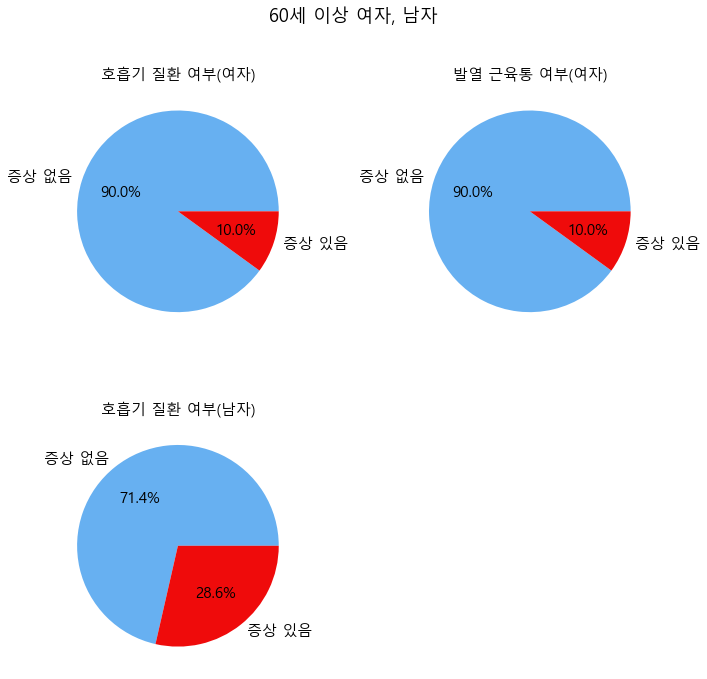

In [68]:
# 60세 이상 
data_covid_60_f = (data_60_f[data_60_f['covid19']==1].reset_index(drop=True))
data_covid_60_m = (data_60_m[data_60_m['covid19']==1].reset_index(drop=True))
plot_covid_age_gender_50_60(data_covid_60_f,data_covid_60_m,'60세 이상 여자, 남자')

- 코로나 양성을 받은 사람들 수를 보겠습니다.

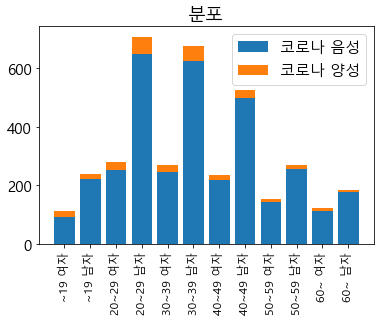

In [69]:
labels = ['~19 여자', '~19 남자', '20~29 여자', '20~29 남자', '30~39 여자', '30~39 남자', '40~49 여자', '40~49 남자', '50~59 여자', '50~59 남자', '60~ 여자', '60~ 남자']
plt.bar(labels,[len(data_0_19_f)-len(data_covid_0_19_f),len(data_0_19_m)-len(data_covid_0_19_m),
               len(data_20_29_f)-len(data_covid_20_29_f),len(data_20_29_m)-len(data_covid_20_29_m),
               len(data_30_39_f)-len(data_covid_30_39_f),len(data_30_39_m)-len(data_covid_30_39_m),
               len(data_40_49_f)-len(data_covid_40_49_f),len(data_40_49_m)-len(data_covid_40_49_m),
                len(data_50_59_f)-len(data_covid_50_59_f),len(data_50_59_m)-len(data_covid_50_59_m),
                len(data_60_f)-len(data_covid_60_f),len(data_60_m)-len(data_covid_60_m)
               ])
plt.bar(labels,[len(data_covid_0_19_f),len(data_covid_0_19_m),
               len(data_covid_20_29_f),len(data_covid_20_29_m),
               len(data_covid_30_39_f),len(data_covid_30_39_m),
               len(data_covid_40_49_f),len(data_covid_40_49_m),
                len(data_covid_50_59_f),len(data_covid_50_59_m),
                len(data_covid_60_f),len(data_covid_60_m)
               ],bottom=[len(data_0_19_f)-len(data_covid_0_19_f),len(data_0_19_m)-len(data_covid_0_19_m),
               len(data_20_29_f)-len(data_covid_20_29_f),len(data_20_29_m)-len(data_covid_20_29_m),
               len(data_30_39_f)-len(data_covid_30_39_f),len(data_30_39_m)-len(data_covid_30_39_m),
               len(data_40_49_f)-len(data_covid_40_49_f),len(data_40_49_m)-len(data_covid_40_49_m),
                len(data_50_59_f)-len(data_covid_50_59_f),len(data_50_59_m)-len(data_covid_50_59_m),
                len(data_60_f)-len(data_covid_60_f),len(data_60_m)-len(data_covid_60_m)
               ])
plt.xticks(rotation=90,size=12)
plt.title('분포')
plt.legend(['코로나 음성','코로나 양성'])
plt.show()

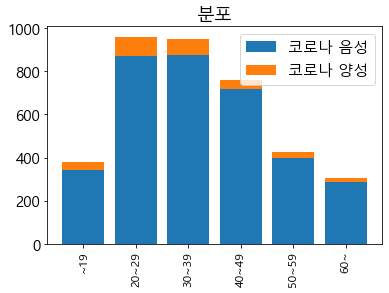

In [70]:
labels = ['~19', '20~29', '30~39','40~49','50~59', '60~']
plt.bar(labels,[len(data_0_19_f)-len(data_covid_0_19_f)+len(data_20_29_f)-len(data_covid_20_29_f),
                len(data_0_19_m)-len(data_covid_0_19_m)+len(data_20_29_m)-len(data_covid_20_29_m),
               len(data_30_39_f)-len(data_covid_30_39_f)+len(data_30_39_m)-len(data_covid_30_39_m),
               len(data_40_49_f)-len(data_covid_40_49_f)+len(data_40_49_m)-len(data_covid_40_49_m),
                len(data_50_59_f)-len(data_covid_50_59_f)+len(data_50_59_m)-len(data_covid_50_59_m),
                len(data_60_f)-len(data_covid_60_f)+len(data_60_m)-len(data_covid_60_m)
               ])
plt.bar(labels,[len(data_covid_0_19_f)+len(data_covid_0_19_m),
               len(data_covid_20_29_f)+len(data_covid_20_29_m),
               len(data_covid_30_39_f)+len(data_covid_30_39_m),
               len(data_covid_40_49_f)+len(data_covid_40_49_m),
                len(data_covid_50_59_f)+len(data_covid_50_59_m),
                len(data_covid_60_f)+len(data_covid_60_m)
               ],bottom=[len(data_0_19_f)-len(data_covid_0_19_f)+len(data_20_29_f)-len(data_covid_20_29_f),
                len(data_0_19_m)-len(data_covid_0_19_m)+len(data_20_29_m)-len(data_covid_20_29_m),
               len(data_30_39_f)-len(data_covid_30_39_f)+len(data_30_39_m)-len(data_covid_30_39_m),
               len(data_40_49_f)-len(data_covid_40_49_f)+len(data_40_49_m)-len(data_covid_40_49_m),
                len(data_50_59_f)-len(data_covid_50_59_f)+len(data_50_59_m)-len(data_covid_50_59_m),
                len(data_60_f)-len(data_covid_60_f)+len(data_60_m)-len(data_covid_60_m)
               ])
plt.xticks(rotation=90,size=12)
plt.title('분포')
plt.legend(['코로나 음성','코로나 양성'])
plt.show()

**결론**

분포, 상관계수를 보았을 때 증상발현이 직접적으로 코로나 양성에 영향이 있는 것으로 볼 수 없습니다.

이에 기침 정보를 통하여 분석해보고 모델을 구현해보겠습니다.

# data shape 확인

data 모양 확인

In [71]:
with open('train.npy', 'rb') as f:
    dataset = np.load(f,allow_pickle=True)

In [72]:
print(dataset[0].shape)
print(dataset[1].shape)
print(dataset[5].shape)
print(dataset[3804].shape)
print(len(dataset))

(78720,)
(39360,)
(152640,)
(106560,)
3805


In [73]:
dataset[0]

array([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
       -1.3607033e-06,  9.0535781e-07, -7.7081609e-07], dtype=float32)

In [74]:
dataset[1]

array([ 0.        ,  0.        ,  0.        , ..., -0.00011289,
       -0.00015794, -0.00019451], dtype=float32)

In [75]:
ipd.Audio('./data/train/00001.wav')

In [76]:
ipd.Audio('./data/train/00002.wav')

In [77]:
sig,sr = librosa.load('./data/train/00001.wav')

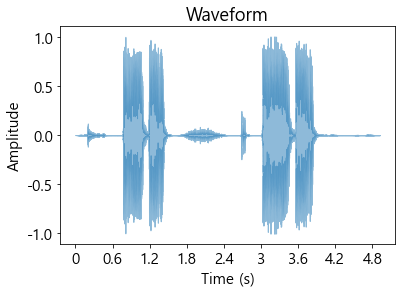

In [78]:
plt.figure()
librosa.display.waveshow(sig,sr,alpha=0.5)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Waveform')
plt.show()

# STFT(Short Time Fourier Transform)

- Fourier Transform에서 구간을 짧게 나누어 나누어진 여러 구간의 데이터를 각각 푸리에 변환하는 방법
- ex) 9초 -> 0 ~ 3초 사이, 3 ~ 6초 사이, 6 ~ 9초 사이
- 단순히 FT를 진행하면 어느 시점에서 주파수 성분이 존재하는지 알 수가 없습니다.
    - 이에 STFT를 진행합니다.
        - STFT를 진행하면 어느 시점에서의 주파수 성분을 정확히 알 수 있습니다.

In [79]:
# 1 wav 파일의 stft 정보
librosa.stft(dataset[0])

array([[-4.01214784e-04+0.0000000e+00j, -2.31889868e-03+0.0000000e+00j,
        -3.66285467e-03+0.0000000e+00j, ...,
        -2.46405182e-03+0.0000000e+00j, -2.96171242e-03+0.0000000e+00j,
        -2.39647692e-03+0.0000000e+00j],
       [-1.19814293e-04-3.2097075e-04j,  1.16641005e-03-1.5498928e-03j,
         2.45719450e-03+2.2438915e-04j, ...,
         9.07013426e-04-9.3157505e-05j,  1.85973675e-03-4.0080521e-04j,
         1.39551249e-03+9.4312412e-04j],
       [ 1.33231631e-04-1.1540110e-04j,  3.63972620e-04+1.2229631e-03j,
        -5.87663963e-04-8.5211766e-04j, ...,
         5.70936536e-04-2.8220329e-05j, -3.81842896e-04+4.9644563e-04j,
        -3.93777518e-05-6.2240579e-04j],
       ...,
       [-3.69108797e-08-3.2311103e-08j, -1.10515501e-07+6.8822793e-08j,
         3.14441934e-07-2.5001847e-07j, ...,
         1.23823270e-07-9.6566914e-08j, -1.68508464e-07+1.4104322e-07j,
         1.08787867e-06-7.7974789e-07j],
       [ 1.25923600e-08-3.6017507e-08j, -1.14884365e-07-1.9730342e-0

In [80]:
librosa.stft(dataset[0]).shape

(1025, 154)

In [81]:
dataset[0].shape

(78720,)

In [82]:
librosa.stft(dataset[1]).shape

(1025, 77)

In [83]:
librosa.stft(dataset[2]).shape

(1025, 297)

- stft로 변경 뒤 specshow로 plot하여 음성을 분석해 보도록 하겠습니다.

In [84]:
def draw_4_stft(dataset1,dataset2,dataset3,dataset4):
    n_fft = 2048 # window의 크기
    hop_length = 512  # window간에 겹치는 사이즈
    
    # 첫 번째 
    fig, axs = plt.subplots(2,2,figsize=(15,10))
    librosa.display.specshow(np.abs(librosa.stft(dataset1,n_fft=n_fft,hop_length=hop_length)),
                            y_axis='hz',x_axis='s',ax=axs[0,0])
    axs[0,0].grid();
    
    # 두 번째
    librosa.display.specshow(np.abs(librosa.stft(dataset2,n_fft=n_fft,hop_length=hop_length)),
                            y_axis='hz',x_axis='s',ax=axs[0,1])
    axs[0,1].grid();
    
    librosa.display.specshow(np.abs(librosa.stft(dataset3,n_fft=n_fft,hop_length=hop_length)),
                            y_axis='hz',x_axis='s',ax=axs[1,0])
    axs[1,0].grid();
    
    librosa.display.specshow(np.abs(librosa.stft(dataset4,n_fft=n_fft,hop_length=hop_length)),
                            y_axis='hz',x_axis='s',ax=axs[1,1])
    axs[1,1].grid();

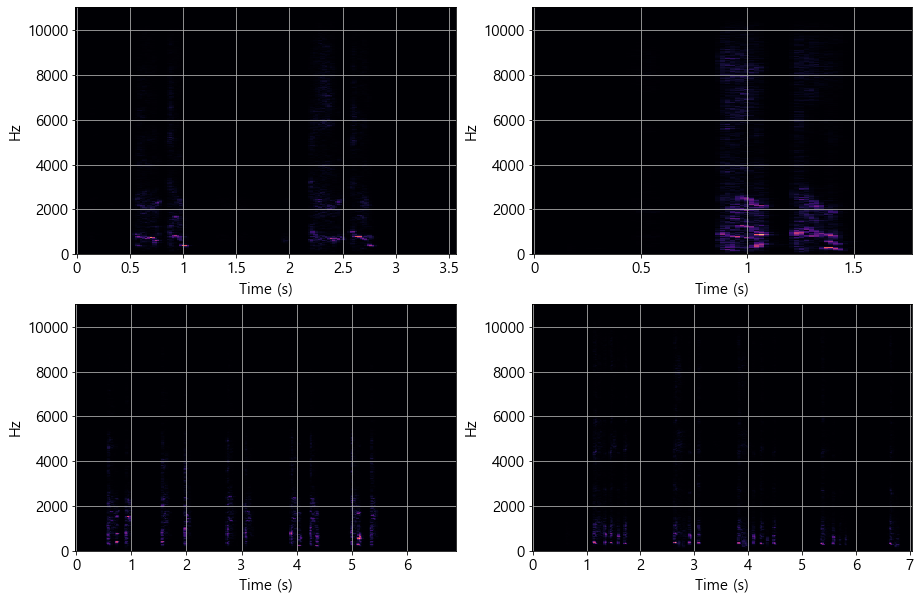

In [85]:
draw_4_stft(dataset[0],dataset[1],dataset[2],dataset[3])

- 코로나 양성자와 음성자끼리 비교해보겠습니다.
- 위 2개가 양성이고, 아래 2개가 음성입니다.

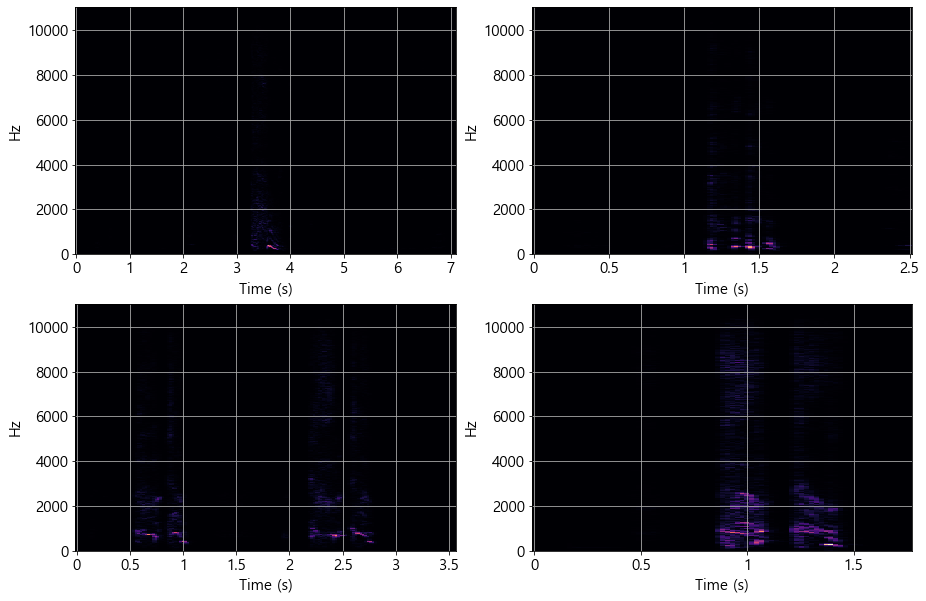

In [86]:
draw_4_stft(dataset[6],dataset[14],dataset[0],dataset[1])

- 기침 녹음 시간이 전부 다 달라서 문제가 될 수 있습니다.

In [87]:
index = data1[data1['covid19']==1].index
index2 = data1[data1['covid19']==0].index

In [88]:
c_time = []
cn_time = []
for i in range(len(index)):
    c_time.append(dataset[index[i]].shape[0]/16000)
for i in range(len(index2)):
    cn_time.append(dataset[index2[i]].shape[0]/16000)

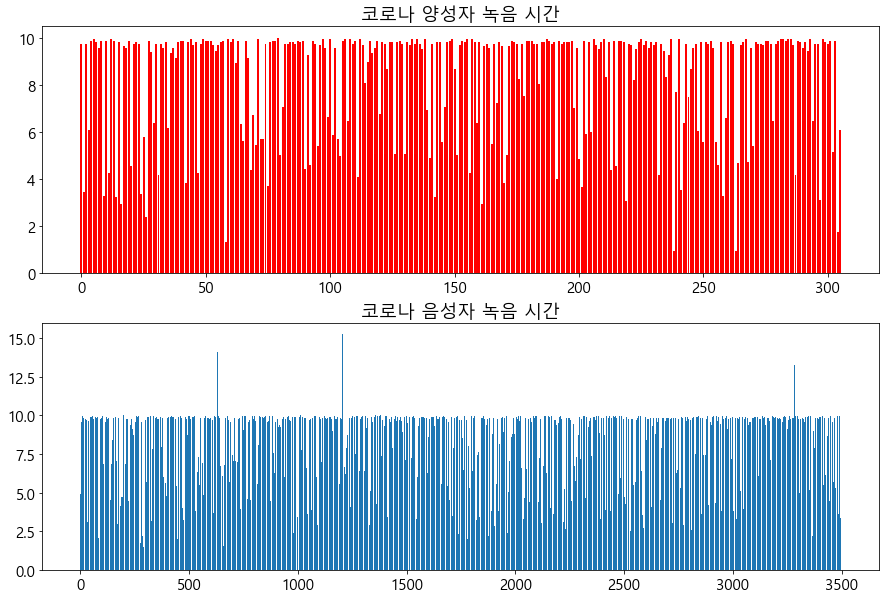

In [89]:
fig, axs = plt.subplots(2,figsize=(15,10))
axs[0].bar(range(len(index)),c_time,color='r')
axs[0].set_title('코로나 양성자 녹음 시간')
axs[1].bar(range(len(index2)),cn_time)
axs[1].set_title('코로나 음성자 녹음 시간')
plt.show()

- 약 10초 정도의 녹음시간이 많은 것으로 확인됩니다. 실제로 그런지 확인해보겠습니다.

In [90]:
c_time = pd.DataFrame(c_time)
c_time.columns = ['녹음 시간']
c_time

녹음 시간
0     9.78
1     3.48
2     9.78
3     6.12
4     9.90
..     ...
301   9.90
302   5.16
303   9.90
304   1.74
305   6.12

[306 rows x 1 columns]

In [91]:
cn_time = pd.DataFrame(cn_time)
cn_time.columns = ['녹음 시간']
cn_time

녹음 시간
0      4.92
1      2.46
2      9.48
3      9.72
4      8.10
...     ...
3494   6.66
3495   3.36
3496   9.96
3497   9.06
3498   6.66

[3499 rows x 1 columns]

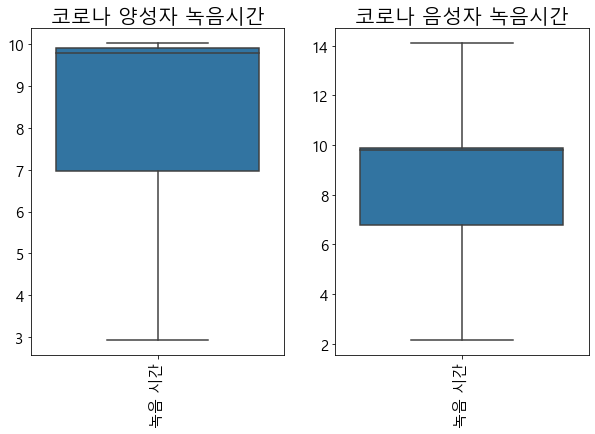

In [92]:
plt.figure(figsize=(10,6)) # 그래프 크기 조정
plt.subplot(1,2,1)
g = sns.boxplot(data=c_time, showfliers=False)
g.set_title('코로나 양성자 녹음시간', size = 20)
g.set_xticklabels(g.get_xticklabels(),rotation=90)
plt.subplot(1,2,2)
g = sns.boxplot(data=cn_time, showfliers=False)
g.set_title('코로나 음성자 녹음시간', size = 20)
g.set_xticklabels(g.get_xticklabels(),rotation=90)
plt.show()

In [93]:
c_time.describe()

녹음 시간
count  306.000000
mean     8.429804
std      2.294338
min      0.960000
25%      6.975000
50%      9.780000
75%      9.900000
max     10.020000

In [94]:
cn_time.describe()

녹음 시간
count  3499.000000
mean      8.314759
std       2.317760
min       0.480000
25%       6.780000
50%       9.780000
75%       9.900000
max      15.240000

- 9.5초~10초 대 사이의 녹음 시간이 굉장히 많음을 볼 수 있습니다.
- 최대 녹음 시간은 약 15초로 확인되었습니다.
    - 10초로 녹음 시간을 설정합니다.
        - 10초보다 작은 값은 10초로 늘리고
        - 10초보다 큰 값은 10초로 줄입니다.
        
        
**녹음 시간 분포를 통하여 녹음시간 전처리를 진행합니다.**

- MFCC(Mel Frequency Cepstral Coefficient)를 구하고 시각화해보겠습니다. 
- MFCC는 오디오 신호 처리 분야에서 많이 사용되는 소리 데이터의 특징값입니다.
- 사람의 청각이 예민하게 반응하는 정보를 강조하여 소리가 가지는 고유한 특징을 추출한 값입니다.

In [95]:
# mfcc 특성 추출 및 sklearn에서의 scale으로 전처리도 진행합니다.
mfcc = []
for i in tqdm(dataset,colour='green'):
    mfcc.append(sklearn.preprocessing.scale(librosa.feature.mfcc(i,sr=16000,n_mfcc=102), axis=1))

100%|██████████████████████████████████████████████████████████████████████████████| 3805/3805 [02:05<00:00, 30.23it/s]


- 전처리 한 뒤, mfcc 특성을 display해보겠습니다.

In [135]:
def get_feature(data, sr = 16000, n_fft = 256, win_length = 200, hop_length = 160, n_mels = 64):
    mel = []
    for i in data:
        # win_length 는 음성을 작은 조각으로 자를때 작은 조각의 크기입니다.
        # hop_length 는 음성을 작은 조각으로 자를때 자르는 간격을 의미합니다.
        # n_mels 는 적용할 mel filter의 개수입니다.
        mel_ = librosa.feature.melspectrogram(i, sr = sr, n_fft = n_fft, win_length = win_length, hop_length = hop_length, n_mels = n_mels)
        mel.append(mel_)
    mel = np.array(mel)
    mel = librosa.power_to_db(mel, ref = np.max)

    mel_mean = mel.mean()
    mel_std = mel.std()
    mel = (mel - mel_mean) / mel_std

    return mel

In [137]:
train_x = np.concatenate(dataset, axis= 0)

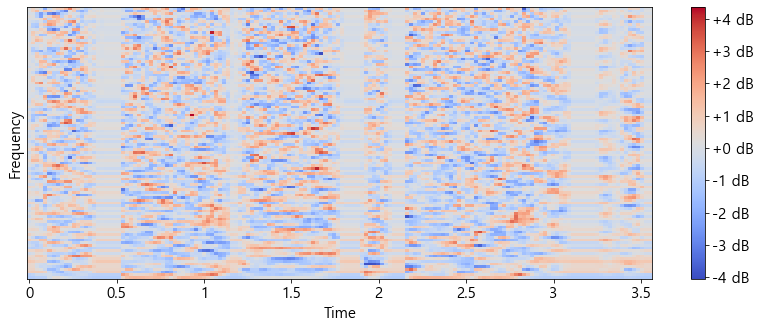

In [96]:
fig = plt.figure(figsize = (14,5))
librosa.display.specshow(mfcc[0], 
                         sr=sr, 
                         x_axis='time',)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')
plt.show()

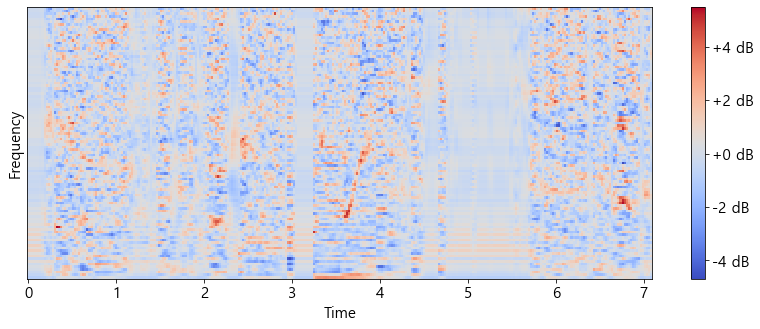

In [133]:
fig = plt.figure(figsize = (14,5))
librosa.display.specshow(mfcc[index[0]], 
                         sr=sr, 
                         x_axis='time',)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')
plt.show()

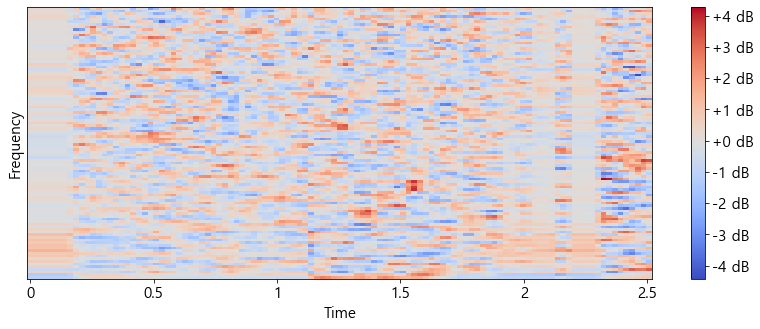

In [134]:
fig = plt.figure(figsize = (14,5))
librosa.display.specshow(mfcc[index[1]], 
                         sr=sr, 
                         x_axis='time',)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')
plt.show()

- 각 녹음 시간이 다 다르기 때문에 shape가 다릅니다.
- 이에 padding을 통하여 shape를 조정합니다.

- shape 조정 전 shape 분포를 확인하여 분석합니다.

In [97]:
mfcc_shape = []
mfcc2_shape = []
for i in range(len(index)):
    mfcc_shape.append(mfcc[index[i]].shape[1])
for i in range(len(index2)):
    mfcc2_shape.append(mfcc[index2[i]].shape[1])

In [98]:
mfcc_shape1 = pd.DataFrame(mfcc_shape)
mfcc_shape1.columns = ['shape']
mfcc_shape1

shape
0      306
1      109
2      306
3      192
4      310
..     ...
301    310
302    162
303    310
304     55
305    192

[306 rows x 1 columns]

In [99]:
mfcc_shape2 = pd.DataFrame(mfcc2_shape)
mfcc_shape2.columns = ['shape']
mfcc_shape2

shape
0       154
1        77
2       297
3       304
4       254
...     ...
3494    209
3495    106
3496    312
3497    284
3498    209

[3499 rows x 1 columns]

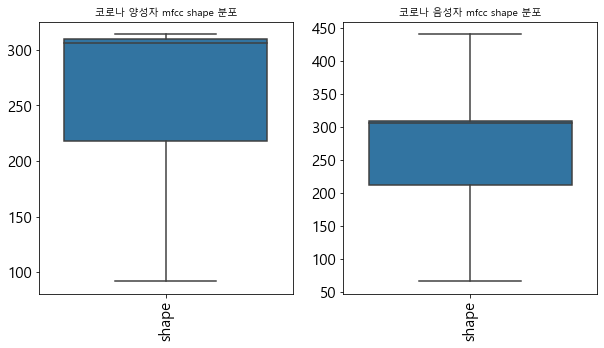

In [100]:
plt.figure(figsize=(10,5)) # 그래프 크기 조정
plt.subplot(1,2,1)
g = sns.boxplot(data=mfcc_shape1, showfliers=False)
g.set_title('코로나 양성자 mfcc shape 분포', size = 10)
g.set_xticklabels(g.get_xticklabels(),rotation=90)
plt.subplot(1,2,2)
g = sns.boxplot(data=mfcc_shape2, showfliers=False)
g.set_title('코로나 음성자 mfcc shape 분포', size = 10)
g.set_xticklabels(g.get_xticklabels(),rotation=90)
plt.show()

In [101]:
mfcc_shape1.describe()

shape
count  306.000000
mean   263.990196
std     71.678814
min     31.000000
25%    218.500000
50%    306.000000
75%    310.000000
max    314.000000

In [102]:
mfcc_shape2.describe()

shape
count  3499.000000
mean    260.402686
std      72.430349
min      16.000000
25%     212.000000
50%     306.000000
75%     310.000000
max     477.000000

In [103]:
mfcc_shape1.sort_values('shape').reset_index(drop=True)

shape
0       31
1       31
2       42
3       55
4       76
..     ...
301    312
302    312
303    312
304    312
305    314

[306 rows x 1 columns]

In [104]:
mfcc_shape.sort()
mfcc2_shape.sort()

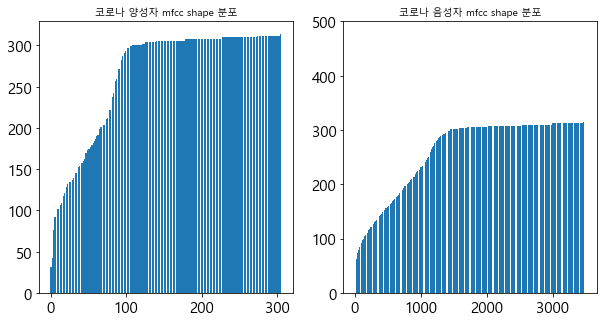

In [105]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.bar(range(len(mfcc_shape)),mfcc_shape)
plt.title('코로나 양성자 mfcc shape 분포',size=10)
plt.subplot(1,2,2)
plt.bar(range(len(mfcc2_shape)),mfcc2_shape)
plt.title('코로나 음성자 mfcc shape 분포',size=10)
plt.show()

In [106]:
real_mfcc_shape = []
for i in range(len(mfcc)):
    real_mfcc_shape.append(mfcc[i].shape[1])
real_mfcc_shape

[154,
 77,
 297,
 304,
 254,
 299,
 306,
 199,
 256,
 308,
 312,
 310,
 310,
 308,
 109,
 306,
 308,
 308,
 312,
 308,
 310,
 312,
 192,
 310,
 160,
 310,
 310,
 310,
 306,
 152,
 308,
 53,
 312,
 304,
 310,
 287,
 308,
 98,
 308,
 107,
 306,
 413,
 302,
 306,
 214,
 167,
 173,
 310,
 177,
 312,
 199,
 134,
 310,
 267,
 293,
 312,
 209,
 310,
 233,
 310,
 166,
 312,
 312,
 308,
 310,
 301,
 287,
 312,
 306,
 310,
 312,
 310,
 121,
 308,
 104,
 98,
 310,
 147,
 312,
 310,
 310,
 295,
 308,
 257,
 308,
 308,
 310,
 134,
 306,
 310,
 310,
 312,
 312,
 310,
 310,
 173,
 312,
 64,
 115,
 301,
 312,
 224,
 145,
 308,
 312,
 158,
 306,
 295,
 209,
 289,
 308,
 308,
 310,
 154,
 310,
 312,
 190,
 164,
 141,
 312,
 214,
 308,
 308,
 137,
 312,
 164,
 211,
 102,
 308,
 312,
 301,
 312,
 199,
 312,
 308,
 310,
 190,
 218,
 74,
 306,
 308,
 306,
 312,
 137,
 145,
 308,
 308,
 312,
 308,
 306,
 175,
 184,
 271,
 312,
 141,
 312,
 128,
 306,
 136,
 214,
 181,
 308,
 310,
 263,
 295,
 188,
 306,
 152

In [107]:
real_mfcc_shape.sort()

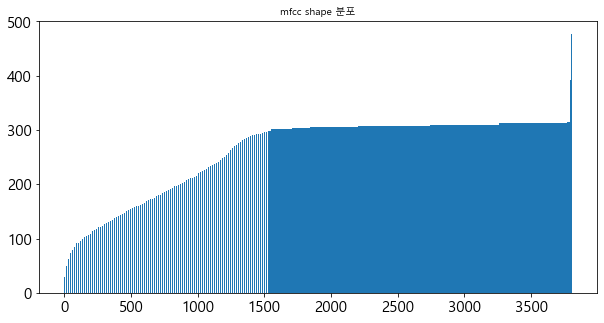

In [108]:
plt.figure(figsize=(10,5))
plt.bar(range(len(real_mfcc_shape)),real_mfcc_shape)
plt.title('mfcc shape 분포',size=10)
plt.show()

In [109]:
mfcc_shape3 = pd.DataFrame(real_mfcc_shape)
mfcc_shape3.columns = ['shape']
mfcc_shape3

shape
0        16
1        29
2        31
3        31
4        31
...     ...
3800    424
3801    428
3802    430
3803    441
3804    477

[3805 rows x 1 columns]

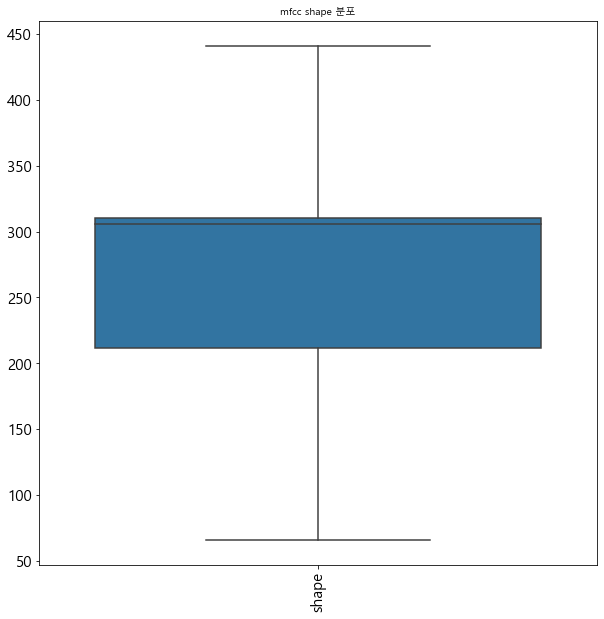

In [110]:
plt.figure(figsize=(10,10)) # 그래프 크기 조정
g = sns.boxplot(data=mfcc_shape3, showfliers=False)
g.set_title('mfcc shape 분포', size = 10)
g.set_xticklabels(g.get_xticklabels(),rotation=90)
plt.show()

In [111]:
mfcc_shape3.describe()

shape
count  3805.000000
mean    260.691196
std      72.367429
min      16.000000
25%     212.000000
50%     306.000000
75%     310.000000
max     477.000000

- 중앙값 306으로 shape를 padding하기로 결정하였습니다.

In [112]:
pad2d = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i-a.shape[1]))))
padded_mfcc = []
for i in range(len(mfcc)):
    padded_mfcc.append(pad2d(mfcc[i], 306))

In [113]:
for i in range(len(padded_mfcc)):
    print(padded_mfcc[i].shape[1])

306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306


306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306
306


In [114]:
len(padded_mfcc)

3805

In [115]:
padded_mfcc[0].shape

(102, 306)

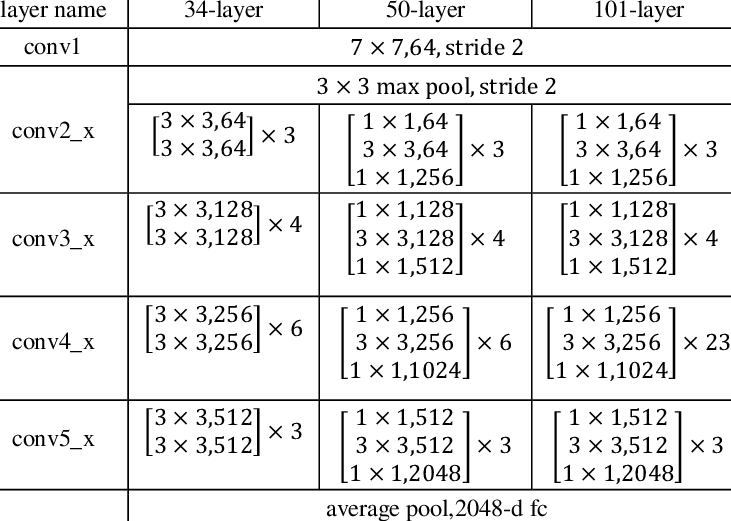

In [116]:
padded_reshape_mfcc = []
for i in tqdm(padded_mfcc,colour='green'):
    padded_reshape_mfcc.append(np.reshape(i,(102,102,3)))

100%|██████████████████████████████████████████████████████████████████████████| 3805/3805 [00:00<00:00, 338192.98it/s]


In [117]:
padded_reshape_mfcc[0].shape

(102, 102, 3)

In [118]:
from keras import models, layers
from keras import Input
from keras.models import Model, load_model
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add
from tensorflow import keras
    
import os
import matplotlib.pyplot as plt
import numpy as np
import math

In [119]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [158]:
def identity_block(x, filter):
    # copy tensor to variable called x_skip
    #x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Add Residue
    #x = tf.keras.layers.Add()([x, x_skip])     
    #x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [121]:
def convolutional_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Processing Residue with conv(1,1)
    x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [159]:
def ResNet18(shape = (102, 102, 3), classes = 2):
    # Step 1 (Setup Input Layer)
    x_input = tf.keras.layers.Input(shape)
    x = tf.keras.layers.ZeroPadding2D((5, 5))(x_input)
    # Step 2 (Initial Conv layer along with maxPool)
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    # Define size of sub-blocks and initial filter size
    block_layers = [2, 2]
    filter_size = 64
    # Step 3 Add the Resnet Blocks
    for i in range(2):
        # For sub-block 1 Residual/Convolutional block not needed
        for j in range(block_layers[i]):
            x = identity_block(x, filter_size)
    # Step 4 End Dense Network
    x = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(classes, activation = 'softmax')(x)
    model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "ResNet18")
    return model

In [123]:
model2 = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(102,102,3),padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1000, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation='softmax')
])

In [166]:
label = np.array(data1['covid19'])

In [175]:
from sklearn.model_selection import train_test_split
train_data, val_data, train_target, val_target = train_test_split(padded_reshape_mfcc,
                                                                      label, test_size=0.1,                                        
                                                                  random_state=42)  

In [171]:
train_data

[array([[[-0.68719548, -0.68719548, -0.68719548],
         [-0.68719548, -0.68719548, -0.68719548],
         [-0.68719548, -0.68719548, -0.68719548],
         ...,
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ]],
 
        [[-0.70965141, -0.70965141, -0.70965141],
         [-0.70965141, -0.70965141, -0.70965141],
         [-0.70965141, -0.70965141, -0.70965141],
         ...,
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ]],
 
        [[-0.43197849, -0.43197849, -0.43197849],
         [-0.43197849, -0.43197849, -0.43197849],
         [-0.43197849, -0.43197849, -0.43197849],
         ...,
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ]],
 
        ...,
 
        [[-0.24054091, -0.24054091

In [149]:
train_data.shape

(3805, 102, 102, 3)

In [150]:
train_data

array([[[[-0.99536407, -0.96874762, -0.8856644 ],
         [-0.87197345, -0.84234399, -0.17435983],
         [ 0.27702221,  0.32438964,  0.12846091],
         ...,
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ]],

        [[-0.84473705, -0.6690371 , -0.30688351],
         [-0.35916859, -0.27706182, -0.20489556],
         [-0.48192835, -0.57000393, -0.88371253],
         ...,
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ]],

        [[ 0.85520071,  0.95679593,  0.94859803],
         [ 0.91123891,  0.76496273, -0.37596014],
         [-0.97187495, -1.47305727, -1.6886009 ],
         ...,
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ]],

        ...,

        [[-0.04866927, -0.04964546, -0

In [131]:
ResNet18().summary()

Model: "ResNet18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 102, 102, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 112, 112, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 56, 56, 64)   9472        ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 56, 56, 64)  256         ['conv2d_5[0][0]']        

 conv2d_12 (Conv2D)             (None, 28, 28, 64)   36928       ['activation_6[0][0]']           
                                                                                                  
 batch_normalization_15 (BatchN  (None, 28, 28, 64)  256         ['conv2d_12[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_7 (Activation)      (None, 28, 28, 64)   0           ['batch_normalization_15[0][0]'] 
                                                                                                  
 dropout_6 (Dropout)            (None, 28, 28, 64)   0           ['activation_7[0][0]']           
                                                                                                  
 conv2d_13 (Conv2D)             (None, 28, 28, 64)   36928       ['dropout_6[0][0]']              
          

 batch_normalization_26 (BatchN  (None, 28, 28, 64)  256         ['add_6[0][0]']                  
 ormalization)                                                                                    
                                                                                                  
 activation_14 (Activation)     (None, 28, 28, 64)   0           ['batch_normalization_26[0][0]'] 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 28, 28, 64)   36928       ['activation_14[0][0]']          
                                                                                                  
 batch_normalization_27 (BatchN  (None, 28, 28, 64)  256         ['conv2d_20[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

In [140]:
from sklearn.model_selection import StratifiedKFold

In [176]:

pred = []
pred_ = []


model = ResNet18()
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt,loss='sparse_categorical_crossentropy',
              metrics='accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)
history =  model.fit(x = np.array(train_data), y = np.array(train_target), validation_data = (np.array(val_data), np.array(val_target)), epochs=20,
                     callbacks=[checkpoint_cb,early_stopping_cb],batch_size = 128)
print("*******************************************************************")
pred.append(model.predict(test_data))
pred_.append(np.argmax(model.predict(test_data), axis = 1))
print("*******************************************************************")

Epoch 1/20
27/27 [==============================] - 91s 3s/step - loss: 1.5336 - accuracy: 0.9098 - val_loss: 5.4837 - val_accuracy: 0.9055
Epoch 2/20
27/27 [==============================] - 89s 3s/step - loss: 0.2882 - accuracy: 0.9197 - val_loss: 1.0835 - val_accuracy: 0.8688
Epoch 3/20
27/27 [==============================] - 89s 3s/step - loss: 0.2770 - accuracy: 0.9209 - val_loss: 0.4327 - val_accuracy: 0.9108
Epoch 4/20
27/27 [==============================] - 88s 3s/step - loss: 0.2751 - accuracy: 0.9206 - val_loss: 0.3759 - val_accuracy: 0.8871
Epoch 5/20
27/27 [==============================] - 84s 3s/step - loss: 0.2690 - accuracy: 0.9209 - val_loss: 0.3775 - val_accuracy: 0.9055
Epoch 6/20
27/27 [==============================] - 85s 3s/step - loss: 0.2640 - accuracy: 0.9209 - val_loss: 0.3564 - val_accuracy: 0.9003
Epoch 7/20
27/27 [==============================] - 87s 3s/step - loss: 0.2615 - accuracy: 0.9209 - val_loss: 0.3424 - val_accuracy: 0.9108
Epoch 8/20
27/27 [==

In [179]:
pred = model.predict(test_data)

In [180]:
test_label = np.argmax(pred, axis = 1)

In [182]:
test_label = pd.DataFrame(test_label)

In [183]:
test_label.value_counts()

0    5732
dtype: int64

- 모델을 학습한 뒤 학습한 모델로 예측값 출력
    - 예측값을 submission 파일에 저장 뒤 제출함

# 문제점

- 과대적합
    - val data 예측률이 정말 높았으나 test data 예측률이 굉장히 낮음
        - 전부 0의 값으로 출력됨
    - 훈련 데이터가 적거나, 규제를 적절히 사용하지 못했거나, 모델이 너무 deep 했을 가능성이 큼
    
    
- 데이터 전처리를 통해 모델이 훈련데이터만 학습하지 않도록 하는 방안이 있음

# 추후 일정

- 추후에 코드 공유를 보며 대회 수상 코드를 공부할 예정임

In [141]:
with open('test_final.npy', 'rb') as f:
    test_data = np.load(f,allow_pickle=True)

In [ ]:
train_data.shape

In [ ]:
model.evaluate(val_data, val_target)

In [ ]:
with open('test.npy', 'rb') as f:
    dataset_test = np.load(f,allow_pickle=True)

In [ ]:
# mfcc 특성 추출 및 sklearn에서의 scale으로 전처리도 진행합니다.
mfcc_test = []
for i in tqdm(dataset_test,colour='green'):
    mfcc_test.append(sklearn.preprocessing.scale(librosa.feature.mfcc(i,sr=16000,n_mfcc=102), axis=1))

In [ ]:
pad2d = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i-a.shape[1]))))
padded_mfcc_test = []
for i in range(len(mfcc_test)):
    padded_mfcc_test.append(pad2d(mfcc_test[i], 306))

In [ ]:
padded_reshape_mfcc_test = []
for i in tqdm(padded_mfcc_test,colour='green'):
    padded_reshape_mfcc_test.append(np.reshape(i,(102,102,3)))

In [ ]:
padded_reshape_mfcc_test

In [ ]:
test_data = np.array(padded_reshape_mfcc_test)

In [ ]:
preds = model.predict(test_data)

In [ ]:
test_target = np.argmax(preds)
print(test_target)

In [ ]:
model.save('best-cnn-model2.h5')

In [ ]:
model = keras.models.load_model('best-cnn-model2.h5')

In [ ]:
preds

In [ ]:
test_target= np.argmax(preds,axis=1)
print(test_target)

In [ ]:
test_label = pd.DataFrame(test_target)

In [ ]:
test_label

In [ ]:
test_label.value_counts()

In [ ]:
submission = pd.read_csv('./data/sample_submission.csv')

In [ ]:
submission

In [ ]:
submission['covid19'] = test_label

In [ ]:
submission.to_csv('submission.csv',index=False)

In [ ]:
with open('test_final.npy', 'wb') as f:
    np.save(f,test_data)